In [ ]:
#!pip install ../input/monaiandeinops/einops-0.4.1-py3-none-any.whl ../input/monaiandeinops/monai-0.9.0-202206131636-py3-none-any.whl

In [ ]:
#import nibabel

In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from matplotlib.patches import Rectangle

from pathlib import Path
from IPython import display
import albumentations as trans
from einops import rearrange
from tqdm.notebook import tqdm

#DATASET_FOLDER = Path("../input/uw-madison-gi-tract-image-segmentation")
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")

TRAIN_FOLDER = DATASET_FOLDER / "train"

WORKING_FOLDER = Path("./")
#MODEL_FOLDER = WORKING_FOLDER/"models"
MODEL_FOLDER = Path('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models')

os.makedirs(MODEL_FOLDER, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Process metadata

In [2]:
df = pd.read_csv(DATASET_FOLDER/"train.csv")
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [3]:
pivoted = df.pivot(index="id", columns="class", values="segmentation")
#Use the pivoted data going forward
df = pivoted
df['id'] = df.index

### Parse out metadata

In [4]:
#Get Case-ID as columns (str and int)
df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
df["case_id"] = df["case_id_str"].apply(lambda x: int(x[4::]))

#Get Day as columns (str and int)
df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
df["day_num"] = df["day_num_str"].apply(lambda x: int(x[3::]))

#Get Slice Identifier as columns (str and int)
df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])
df["slice_num"] = df["slice_id"].apply(lambda x: int(x[6::]))

# Create the path to get to the file
df['match'] = df.case_id_str + '/' + df.case_id_str + '_' + df.day_num_str + '/scans/' + df.slice_id
df.head()

class,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match
id,,,,,,,,,,,
case101_day20_slice_0001,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001
case101_day20_slice_0002,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002
case101_day20_slice_0003,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003
case101_day20_slice_0004,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004
case101_day20_slice_0005,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005


### Get paths

In [5]:
all_imgs = glob.glob(os.path.join(str(DATASET_FOLDER), "train", "case*", "case*_day*", "scans", "*.png"))
all_imgs = [p.replace(str(DATASET_FOLDER)+'/train/', "") for p in all_imgs]

#check that they match in count
print(f"images: {len(all_imgs)}")
print(f"metadata: {len(df['id'].unique())}")
file_df = pd.DataFrame(all_imgs)
file_df.columns = ["subpath"]
file_df.head()

images: 38496
metadata: 38496


,subpath
0,case24/case24_day25/scans/slice_0046_266_266_1...
1,case24/case24_day25/scans/slice_0099_266_266_1...
2,case24/case24_day25/scans/slice_0013_266_266_1...
3,case24/case24_day25/scans/slice_0064_266_266_1...
4,case24/case24_day25/scans/slice_0090_266_266_1...


### Get image metadata from file name

In [6]:
def trunc_at(s, n=3):
    "Returns s truncated at the n'th (3rd by default) occurrence of the delimiter, d."
    return '_'.join(s.split('_', n)[:n])
file_df['filename'] = file_df["subpath"].apply(lambda x: x.split("/")[-1])
file_df["match"] = file_df["subpath"].apply(trunc_at)
#Get image slice height in pixels
file_df["im_height"] = file_df["filename"].apply(lambda x: int(x.split("_", 5)[2]))

#Get image slice width in pixels
file_df["im_width"] = file_df["filename"].apply(lambda x: int(x.split("_", 5)[3]))

#Get image pixel height in mm
file_df["im_pixel_height"] = file_df["filename"].apply(lambda x: float(x.split("_", 5)[4]))

#Get image pixel width in mm
file_df["im_pixel_width"] = file_df["filename"].apply(lambda x: float(x.split("_", 5)[5].split(".png",1)[0]))

#Define physical slice thickness in mm (3.0 mm for all files)
file_df["slice_thickness"] = 3.0
file_df.head()

,subpath,filename,match,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness
0,case24/case24_day25/scans/slice_0046_266_266_1...,slice_0046_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0046,266,266,1.5,1.5,3.0
1,case24/case24_day25/scans/slice_0099_266_266_1...,slice_0099_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0099,266,266,1.5,1.5,3.0
2,case24/case24_day25/scans/slice_0013_266_266_1...,slice_0013_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0013,266,266,1.5,1.5,3.0
3,case24/case24_day25/scans/slice_0064_266_266_1...,slice_0064_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0064,266,266,1.5,1.5,3.0
4,case24/case24_day25/scans/slice_0090_266_266_1...,slice_0090_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0090,266,266,1.5,1.5,3.0


### Merge dfs

In [7]:
#create our final dataframe by joining the two dataframes
df2d = pd.merge(df, file_df, on = "match", how = "inner")
df.head()

class,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match
id,,,,,,,,,,,
case101_day20_slice_0001,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001
case101_day20_slice_0002,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002
case101_day20_slice_0003,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003
case101_day20_slice_0004,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004
case101_day20_slice_0005,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005


### Add extra columns

In [8]:
# Identify images without segmentation
#For each row find segmentations for each organ
sel1 = ~df2d.large_bowel.isnull()
sel2 = ~df2d.small_bowel.isnull()
sel3 = ~df2d.stomach.isnull()

# select rows with segments
sel_segments = sel1 | sel2 | sel3

#create a new column reflecting whether segmentations exist
df2d['segmentations'] = sel_segments
df2d['group'] = df2d.groupby(['case_id', 'day_num']).ngroup()
df2d.head()

,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations,group
0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150


## Train and Validation split

In [9]:
n_folds = 5
seed = 42

In [10]:
#We will use n fold cross validation, which will create 5 training sets of 80% of the data
# and 5 validation sets of 20% of the data.
# We use the group ID to stratify the folds so that cases are not split between training and val sets

skf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df2d, df2d['segmentations'], groups = df2d["group"])):
    df2d.loc[val_idx, 'fold'] = fold


In [11]:
np.unique(df2d['fold'])

array([0., 1., 2., 3., 4.])

## Utils

In [12]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape, color_val=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, color_val - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

    img = torch.zeros(shape[1]*shape[2])
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color_val
    return img.reshape(shape)    


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Generate 3d images

In [13]:
from monai.transforms import LoadImage
from monai.data import NibabelWriter

def make_mask(shape, lb, sb, st):
    mask = np.zeros((4, shape[0], shape[1]))
    if isinstance(lb, str):
        mask[1,:,:] = rle_decode(lb, [1, shape[0], shape[1]] ,color_val=1)

    if isinstance(sb, str):
        mask[2,:,:] = rle_decode(sb, [1, shape[0], shape[1]] ,color_val=1)

    if isinstance(st, str):
        mask[3,:,:] = rle_decode(st, [1, shape[0], shape[1]] ,color_val=1)
    # Add background channel
    mask[0,:,:] = 1.0*((mask[1,:,:] + mask[2,:,:] + mask[3,:,:]) == 0)
    return mask

def create_image(df, src, dest, idx, writer, loader):
    img_dest = Path(f"{dest}/img_{idx}.nii.gz")
    mask_dest = Path(f"{dest}/mask_{idx}.nii.gz")
    if img_dest.exists() and mask_dest.exists():
        # Cache images already present
        return 
    slices = df.reset_index()
    row = slices.iloc[0]
    img = rearrange(loader(src / row['subpath']), 'w h -> h w')
    im_spacing = row["im_pixel_height"]
    im_affine = np.eye(4)*im_spacing
    im_affine[2,2] = 3 # All slice thicknesses are 3
    im_affine[3,3] = 1
    mask = np.zeros((slices.shape[0], 4, img.shape[0], img.shape[1]))
    for j in range(1, slices.shape[0]):
        row = slices.iloc[j]
        slice_ = rearrange(loader(src / row['subpath']), 'w h -> h w')
        img = np.dstack((img, slice_))
        mask[j,:,:,:] = make_mask(img.shape, row.large_bowel, row.small_bowel, row.stomach)
    
    # Write image
    writer.set_data_array(img, channel_dim=None)
    writer.set_metadata({
        "affine": im_affine,
        "original_affine": im_affine,
        "dtype": np.int16
    })
    writer.write(
        str(img_dest),
        verbose=False
    )
    # Write mask
    # Move channel to last dimension
    mask = rearrange(mask, 'd c h w -> h w d c')

    writer.set_data_array(mask, channel_dim=-1)
    writer.set_metadata({
        "affine": im_affine,
        "original_affine": im_affine,
        "dtype": np.int16
    })
    writer.write(
        str(mask_dest),
        verbose=False
    )

In [14]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
print(multiprocessing.cpu_count())
def create_images(df, src, dest):
    writer = NibabelWriter()
    loader = LoadImage(image_only=True)
    futures = []
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as pool:
        for name, group in df.groupby(['group']):
            group = group.sort_values('slice_num', ascending=True)
            case  = np.unique(group['case_id'])[0]
            day  = np.unique(group['day_num'])[0]
            fold = np.unique(group['fold'])[0]
            n_slice = group.shape[0]
            dest_folder = dest / f"{int(fold)}/case-{case}_day-{day}"
            dest_folder.mkdir(parents=True, exist_ok=True)
            futures.append(
                pool.submit(
                    create_image, group, src, dest_folder, 0, writer, loader
            )
        )
        pbar = tqdm(total=len(futures))
        for _ in as_completed(futures):
            pbar.update(1)
        pbar.close()


12


In [15]:
DEST = Path('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/images')
DEST.mkdir(exist_ok=True)
#df2d[df2d['case_id'] == 29][df2d['day_num'] == 13]

In [16]:
#create_images(df2d, TRAIN_FOLDER, DEST)

## Monai imports

In [17]:
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    Resized,
    LoadImaged,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
    ToTensord,
    SpatialPadd,
    Lambdad,
    CastToTyped,
    RandAffined,
    RandScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGridDistortiond,
    Rand3DElasticd,
    RandCoarseDropoutd,
    Pad,
    MapTransform,
    InvertibleTransform,
    Randomizable,
    ToDeviced,
    EnsureTyped,
    RandCoarseShuffled,
    RandSpatialCropd,
)

#from monai.transforms import Padd

from monai.networks.nets import UNet, AttentionUnet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, Dataset, decollate_batch, list_data_collate, CacheDataset, PersistentDataset

## Transforms for train and validation

In [18]:
from typing import Any, Callable, List, Optional, Sequence, Tuple, Union
from typing import Any, Callable, Dict, Hashable, List, Mapping, Optional, Sequence, Union
from monai.config import IndexSelection, KeysCollection
from monai.data.meta_tensor import MetaTensor
from monai.utils import (
    PytorchPadMode,
    ensure_tuple_rep

)






class SquarePad(Pad):
    """
    Performs padding to the data, making WxH square using max(W,H).

    Args:
        dim1: The first dimension to pad to a square.
        dim2: The second dimension to pad to a square.
        mode: available modes for numpy array:{``"constant"``, ``"edge"``, ``"linear_ramp"``, ``"maximum"``,
            ``"mean"``, ``"median"``, ``"minimum"``, ``"reflect"``, ``"symmetric"``, ``"wrap"``, ``"empty"``}
            available modes for PyTorch Tensor: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}.
            One of the listed string values or a user supplied function. Defaults to ``"constant"``.
            See also: https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
            https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
        kwargs: other arguments for the `np.pad` or `torch.pad` function.
            note that `np.pad` treats channel dimension as the first dimension.

    """

    def __init__(
        self,
        #spatial_size: Union[Sequence[int], int],
        dim1: int,
        dim2: int,
        mode: str = PytorchPadMode.CONSTANT,
        **kwargs,
    ) -> None:
        #self.spatial_size = spatial_size
        self.dim1 = dim1
        self.dim2 = dim2
        super().__init__(to_pad=None,mode=mode, **kwargs)


    def compute_pad_width(self, spatial_shape: Sequence[int]) -> List[Tuple[int, int]]:
        """
        Square the rectange of dim1 and dim2.

        Args:
            dim1: first dimension of the square.
            dim2: second dimension fo the square.

        """
        
            
        square_width = max(spatial_shape[self.dim1],spatial_shape[self.dim2])

        pad_width = [0]*len(spatial_shape)

        p1 = max(0,square_width - spatial_shape[self.dim1])
        p2 = max(0,square_width - spatial_shape[self.dim2])

        pad_width[self.dim1] = (p1 // 2, p1 - (p1 // 2))
        pad_width[self.dim2] = (p2 // 2, p2 - (p2 // 2))

        pad_width = []
        for i, sp_i in enumerate(spatial_size):
            width = max(sp_i - spatial_shape[i], 0)
            pad_width.append((width // 2, width - (width // 2)))
        
        return [(0, 0)] + pad_width

In [19]:
class Padd(MapTransform, InvertibleTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.Pad`.

    """

    backend = Pad.backend


    def __init__(
        self,
        keys: KeysCollection,
        padder: Pad,
        mode = PytorchPadMode.CONSTANT,
        allow_missing_keys: bool = False,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            padder: pad transform for the input image.
            mode: available modes for numpy array:{``"constant"``, ``"edge"``, ``"linear_ramp"``, ``"maximum"``,
                ``"mean"``, ``"median"``, ``"minimum"``, ``"reflect"``, ``"symmetric"``, ``"wrap"``, ``"empty"``}
                available modes for PyTorch Tensor: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}.
                One of the listed string values or a user supplied function. Defaults to ``"constant"``.
                See also: https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
                https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
                It also can be a sequence of string, each element corresponds to a key in ``keys``.
            allow_missing_keys: don't raise exception if key is missing.

        """
        super().__init__(keys, allow_missing_keys)
        self.padder = padder
        self.mode = ensure_tuple_rep(mode, len(self.keys))



    def __call__(self, data: Mapping[Hashable, torch.Tensor]) -> Dict[Hashable, torch.Tensor]:
        d = dict(data)
        for key, m in self.key_iterator(d, self.mode):
            d[key] = self.padder(d[key], mode=m)
        return d



    def inverse(self, data: Mapping[Hashable, MetaTensor]) -> Dict[Hashable, MetaTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.padder.inverse(d[key])
        return d

In [20]:
class SquarePadd(Padd):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.SpatialPad`.
    Performs padding to the data, symmetric for all sides or all on one side for each dimension.

    """


    def __init__(
        self,
        keys: KeysCollection,
        dim1: int,
        dim2: int,
        mode = PytorchPadMode.CONSTANT,
        allow_missing_keys: bool = False,
        **kwargs,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            
            
            
            mode: available modes for numpy array:{``"constant"``, ``"edge"``, ``"linear_ramp"``, ``"maximum"``,
                ``"mean"``, ``"median"``, ``"minimum"``, ``"reflect"``, ``"symmetric"``, ``"wrap"``, ``"empty"``}
                available modes for PyTorch Tensor: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}.
                One of the listed string values or a user supplied function. Defaults to ``"constant"``.
                See also: https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
                https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
                It also can be a sequence of string, each element corresponds to a key in ``keys``.
            allow_missing_keys: don't raise exception if key is missing.
            kwargs: other arguments for the `np.pad` or `torch.pad` function.
                note that `np.pad` treats channel dimension as the first dimension.

        """
        padder = SquarePad(dim1,dim2, **kwargs)
        super().__init__(keys, padder=padder, mode=mode, allow_missing_keys=allow_missing_keys)

In [21]:
#from monai.data.utils import get_random_patch, get_valid_patch_size

from monai.transforms.croppad.array import CenterSpatialCrop
from monai.config.type_definitions import NdarrayOrTensor

from monai.utils import fall_back_tuple

from monai.data.utils import get_random_patch, get_valid_patch_size

#from monai.config import KeysCollection

class RandZCropd(Randomizable, MapTransform, InvertibleTransform):
    """
    Random crops in Z direction only

    Args:
        keys: keys of the corresponding items to be transformed.
            See also: monai.transforms.MapTransform
        roi_size: if `random_size` is True, it specifies the minimum crop region.
            if `random_size` is False, it specifies the expected ROI size to crop. e.g. [224, 224, 128]
            if a dimension of ROI size is bigger than image size, will not crop that dimension of the image.
            If its components have non-positive values, the corresponding size of input image will be used.
            for example: if the spatial size of input data is [40, 40, 40] and `roi_size=[32, 64, -1]`,
            the spatial size of output data will be [32, 40, 40].
        max_roi_size: if `random_size` is True and `roi_size` specifies the min crop region size, `max_roi_size`
            can specify the max crop region size. if None, defaults to the input image size.
            if its components have non-positive values, the corresponding size of input image will be used.
        random_center: crop at random position as center or the image center.
        random_size: crop with random size or specific size ROI.
            if True, the actual size is sampled from:
            `randint(roi_scale * image spatial size, max_roi_scale * image spatial size + 1)`.
        allow_missing_keys: don't raise exception if key is missing.
    """

    backend = CenterSpatialCrop.backend

    def __init__(
        self,
        keys: KeysCollection,
        roi_size: Union[Sequence[int], int],
        max_roi_size: Optional[Union[Sequence[int], int]] = None,
        random_center: bool = True,
        random_size: bool = True,
        allow_missing_keys: bool = False,
    ) -> None:
        MapTransform.__init__(self, keys, allow_missing_keys)
        self.roi_size = roi_size
        self.max_roi_size = max_roi_size
        self.random_center = random_center
        self.random_size = random_size
        self._slices: Optional[Tuple[slice, ...]] = None
        self._size: Optional[Sequence[int]] = None


    def randomize(self, img_size: Sequence[int]) -> None:
        self._size = fall_back_tuple(self.roi_size, img_size)
        if self.random_size:
            max_size = img_size if self.max_roi_size is None else fall_back_tuple(self.max_roi_size, img_size)
            if any(i > j for i, j in zip(self._size, max_size)):
                raise ValueError(f"min ROI size: {self._size} is bigger than max ROI size: {max_size}.")
            self._size = [self.R.randint(low=self._size[i], high=max_size[i] + 1) for i in range(len(img_size))]
        if self.random_center:
            valid_size = get_valid_patch_size(img_size, self._size)
            p = get_random_patch(img_size, valid_size, self.R)
            #print(p)
            self._slices = (slice(None),) + p



    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        first_key: Union[Hashable, List] = self.first_key(d)
        if first_key == []:
            return d

        self.randomize(d[first_key].shape[1:])  # type: ignore
        if self._size is None:
            raise RuntimeError("self._size not specified.")
        for key in self.key_iterator(d):
            if self.random_center:
                self.push_transform(d, key, {"slices": [(i.start, i.stop) for i in self._slices[1:]]})  # type: ignore
                d[key] = d[key][self._slices]
            else:
                self.push_transform(d, key)
                cropper = CenterSpatialCrop(self._size)
                d[key] = cropper(d[key])
        return d



    def inverse(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = deepcopy(dict(data))

        for key in self.key_iterator(d):
            transform = self.get_most_recent_transform(d, key)
            # Create inverse transform
            orig_size = transform[TraceKeys.ORIG_SIZE]
            random_center = self.random_center
            pad_to_start = np.empty((len(orig_size)), dtype=np.int32)
            pad_to_end = np.empty((len(orig_size)), dtype=np.int32)
            if random_center:
                for i, _slice in enumerate(transform[TraceKeys.EXTRA_INFO]["slices"]):
                    pad_to_start[i] = _slice[0]
                    pad_to_end[i] = orig_size[i] - _slice[1]
            else:
                current_size = d[key].shape[1:]
                for i, (o_s, c_s) in enumerate(zip(orig_size, current_size)):
                    pad_to_start[i] = pad_to_end[i] = (o_s - c_s) / 2
                    if o_s % 2 == 0 and c_s % 2 == 1:
                        pad_to_start[i] += 1
                    elif o_s % 2 == 1 and c_s % 2 == 0:
                        pad_to_end[i] += 1
            # interleave mins and maxes
            pad = list(chain(*zip(pad_to_start.tolist(), pad_to_end.tolist())))
            inverse_transform = BorderPad(pad)
            # Apply inverse transform
            d[key] = inverse_transform(d[key])
            # Remove the applied transform
            self.pop_transform(d, key)

        return d

In [22]:
RAND_SAMPLES=4  ## No longer used since we are using the simpler crop

def deg_to_rad(d):
    return d*0.01745329

train_transforms=[]

t = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        EnsureTyped(keys=["img", "mask"],dtype=torch.float32),
        ToDeviced(keys=["img", "mask"], device=device),
        #Lambdad(keys=['mask'], func=lambda mask: print(mask.shape),
        ScaleIntensityd(keys=["img","mask"]),
        
        SquarePadd(keys=["img","mask"],dim1=0,dim2=1),
        #SpatialPadd(keys=["img","mask"],spatial_size=(360,360,-1)),
        Resized(keys=["img","mask"],spatial_size=(256,256,-1)),
        RandZCropd(keys=["img", "mask"], roi_size=(256,256,16), random_size=False,
                         max_roi_size=None, random_center=True),
        
        

        
        
    ]
)

train_transforms.append(t)

t = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        EnsureTyped(keys=["img", "mask"],dtype=torch.float32),
        ToDeviced(keys=["img", "mask"], device=device),
        
        #Lambdad(keys=['mask'], func=lambda mask: print(mask.shape),
        ScaleIntensityd(keys=["img","mask"]),
        SquarePadd(keys=["img","mask"],dim1=0,dim2=1),
        #SpatialPadd(keys=["img","mask"],spatial_size=(360,360,-1)),
        Resized(keys=["img","mask"],spatial_size=(256,256,-1)),
        
        RandZCropd(keys=["img", "mask"], roi_size=(256,256,16), random_size=False,
                         max_roi_size=None, random_center=True),
        RandCoarseShuffled(keys=["img", "mask"], max_holes=8, holes=2,
                           spatial_size=(256//20,256//20,1), max_spatial_size=(256//10,256//10,4),
                           prob=0.5),
        
        # Random transforms
        # Approx 10% chance of up to 10 degree random rotation
        #RandRotated(keys=['img', 'mask'],prob=1.0, range_z=deg_to_rad(15), padding_mode="zeros"),
        #RandZoomd(keys=['img', 'mask'],prob=1.0,min_zoom=(.95,.95,.95),max_zoom=(1.05,1.05,1.05)),
        Rand3DElasticd(keys=['img', 'mask'],prob=0.5, sigma_range=(10,30), magnitude_range=(50,150),
                       spatial_size=None, rotate_range=(.01,.01,.1), shear_range=None,
                       translate_range=None, scale_range=(.05,.05,.05),device=device),
        RandGridDistortiond(keys=['img', 'mask'],prob=0.5,num_cells=10, distort_limit=0.2,
                            padding_mode="zeros",device=device),
        #RandAffined(keys=['img', 'mask'],rotate_range=[-0.2, 0.2],),
        
        
        
        #SpatialPadd(keys=['img', 'mask'], spatial_size=[256,256,16]),
        #CastToTyped(keys=['img', 'mask'])
        
        
    ]
)

train_transforms.append(t)


val_transforms = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        ScaleIntensityd(keys=["img","mask"]),
        
    ]
)

val_transforms_old = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        ScaleIntensityd(keys=["img","mask"]),
        # Random transforms
        RandCropByPosNegLabeld(
            # Note x,y,z here must be divisible by 16
            keys=["img", "mask"],
            label_key="mask",
            spatial_size=[128, 128, 16],
            pos=1,
            neg=1,
            num_samples=2
        ),
        SpatialPadd(keys=['img', 'mask'], spatial_size=[128,128,16]),
        CastToTyped(keys=['img', 'mask'])
    ]
)

## Function to get dataloaders

In [23]:
import tempfile
def get_data_dict_list(df):
    data = []
    for name, group in df.groupby(['group']):
        entry = {}
        case  = np.unique(group['case_id'])[0]
        day  = np.unique(group['day_num'])[0]
        fold = np.unique(group['fold'])[0]
        n_slice = group.shape[0]
        dest_folder = DEST / f"{int(fold)}/case-{case}_day-{day}"
        img = Path(f"{dest_folder}/img_0.nii.gz")
        mask = Path(f"{dest_folder}/mask_0.nii.gz")
        if not (img.exists() and img.is_file()):
            raise RuntimeError(f'{img} doesnt exist')
        if not (mask.exists() and mask.is_file()):
            raise RuntimeError(f'{mask} doesnt exist')
        entry['img'] = img
        entry['mask'] = mask
        data.append(entry)
    return data
    
def get_data_loader(df, fold,train_trans,train_batch_size):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    
    train = get_data_dict_list(train_df)
    valid = get_data_dict_list(valid_df)
    print("Train Length:",len(train),"Val Length:",len(valid))
    
    persistent_cache = DATASET_FOLDER/"persistent_cache"
    persistent_cache.mkdir(parents=True, exist_ok=True)
    
    #train_ds = CacheDataset(
    train_ds = Dataset(
    #train_ds = PersistentDataset(
        data=train, 
        transform=train_trans,
        #cache_rate=1.0,
        #num_workers=8,
        #copy_cache=False,
        #cache_dir=persistent_cache,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=list_data_collate,
        pin_memory=False,
    )
    
    # Use other fold ids for validation
    # Validation set loader
    val_ds = Dataset(
    #val_ds = PersistentDataset(
        data=valid,
        transform=val_transforms,
        #cache_dir=persistent_cache,
        #cache_dir=tempfile.gettempdir()
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        num_workers=0,
        collate_fn=list_data_collate
    )
    return train_loader, val_loader

### Inspect one batch

In [ ]:
from matplotlib import animation

def plot_data3d(image, mask):
    frames = 16
    interval = 200
    start_frame = 0
    img = rearrange(image, 'n c h w d -> n h w d c')
    mask = rearrange(mask, 'n c h w d -> n h w d c')
    # Plot first 4 images
    fig, ax = plt.subplots(2, 4, figsize=(15,10))
    print(image.shape, img.shape)
    ax = ax.ravel()
    ims = []
    masks = []

    # Start by adding the image to each axis
    for i in range(len(ax)):
        im_min = img[i].min()
        im_max = img[i].max()
        # Plot the i'th image at the starting frame
        im_plot = ax[i].imshow(
            img[i,:,:,start_frame,:],
            cmap='bone',
            vmin=im_min,
            vmax=im_max
        )
        print(mask.max())
        mask_plot = ax[i].imshow(mask[i,:,:,start_frame,1:4], alpha=0.3)
        ims.append(im_plot)
        masks.append(mask_plot)
    print(im_min, im_max)
        
    def animate(frame):
        for i in range(len(ax)):
            # Update the i'th image to the data from the j'th frame
            ims[i].set_array(img[i,:,:,frame])
            masks[i].set_array(mask[i,:,:,frame,1:4])
        return ims, masks
    anim = animation.FuncAnimation(fig, animate, interval=interval, frames=frames)
    video = anim.to_html5_video()
  
    # embedding for the video
    html = display.HTML(video)
  
    # draw the animation
    display.display(html)
    plt.tight_layout()
    plt.close()

In [ ]:
def plot_data3d(image, mask,b,start_frame):
    
    img = rearrange(image, 'n c h w d -> n h w d c').cpu().numpy()
    mask = rearrange(mask, 'n c h w d -> n h w d c').cpu().numpy()
    # Plot first 4 images
    fig, ax = plt.subplots(4, 4, figsize=(20,20))
    
    #print(image.shape, img.shape)
    ax = ax.ravel()
    ims = []
    masks = []

    # Start by adding the image to each axis
    for i in range(len(ax)):
        im_min = img[b].min()
        im_max = img[b].max()
        # Plot the i'th image at the starting frame
        im_plot = ax[i].imshow(
            img[b,:,:,start_frame+i,:],
            cmap='bone',
            vmin=im_min,
            vmax=im_max
        )
        #print(mask.max())
        mask_plot = ax[i].imshow(mask[b,:,:,start_frame+i,1:4], alpha=0.3)
        #ims.append(im_plot)
        #masks.append(mask_plot)
        ax[i].axis('off')
    print(im_min, im_max)
    print(img.shape)

In [ ]:
import gc
gc.collect()

In [ ]:
from monai.utils.misc import first
fold = 0
#train_ds, val_ds = get_data_loader(df2d, fold,train_transforms[1],4)

In [ ]:
#check_data = first(train_ds)

In [ ]:
#data = iter(train_ds)

In [ ]:
#check_data = next(data)

In [ ]:

#plot_data3d(check_data['img'], check_data['mask'],0,0)

## Model

In [24]:
def plot_metrics(loss, metric):
    fig, ax = plt.subplots(1,2)
    loss_line, = ax[0].plot(loss, label='loss')
    metric_line, = ax[1].plot(metric, label='metric')
    ax[0].legend(handles=[loss_line])
    ax[1].legend(handles=[metric_line])

### Training phase 1

In [ ]:
#Training settings


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 1
load_weights = False

tr_transforms = train_transforms[0]
batch_size = 8

#tr_transforms = train_transforms[1]
#batch_size = 4

num_epochs = 10
num_folds = 5
start_fold = 0
val_interval = 1
roi_size = (256, 256, 80)


metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=True, softmax=True)

LR = torch.optim.lr_scheduler.OneCycleLR
max_learning_rate = 0.001


In [ ]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()

for fold in range(start_fold, start_fold + num_folds):

    
    model = UNet(
    spatial_dims=3,
    in_channels=1,
    # With softmax 
    out_channels=4,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
    num_res_units=2,
    norm="batch",
    

    )
    model.to(device)
    if load_weights:
            model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))
    
    optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs[0], y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

In [ ]:
::::::::::::::::::::::: # Stop

### Training phase 2

In [25]:
def epochs_in_time(time_avail_hrs, batch_time_min):
    return time_avail_hrs/(batch_time_min*5/60)

In [27]:
epochs_in_time(time_avail_hrs=12, batch_time_min=3)

48.0

In [31]:
#Training settings


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 2
load_weights = True

tr_transforms = train_transforms[0]
batch_size = 8

#tr_transforms = train_transforms[1]
#batch_size = 4

num_epochs = 30
num_folds = 5
start_fold = 0
val_interval = 1
roi_size = (256, 256, 80)


metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.OneCycleLR

max_learning_rate = 0.001


----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/30  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0946


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24815461039543152
saved new best metric model
current epoch: 1 current mean dice: 0.2482 best mean dice: 0.2482 at epoch 1
----------
epoch 2/30  LR=6.917628898445236e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0864


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24992215633392334
saved new best metric model
current epoch: 2 current mean dice: 0.2499 best mean dice: 0.2499 at epoch 2
----------
epoch 3/30  LR=0.00015315825660904177


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0765


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24933119118213654
current epoch: 3 current mean dice: 0.2493 best mean dice: 0.2499 at epoch 2
----------
epoch 4/30  LR=0.0002817363938866931


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0836


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2469867467880249
current epoch: 4 current mean dice: 0.2470 best mean dice: 0.2499 at epoch 2
----------
epoch 5/30  LR=0.0004392797304411763


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0768


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2468845099210739
current epoch: 5 current mean dice: 0.2469 best mean dice: 0.2499 at epoch 2
----------
epoch 6/30  LR=0.000606636058293789


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0710


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2469118982553482
current epoch: 6 current mean dice: 0.2469 best mean dice: 0.2499 at epoch 2
----------
epoch 7/30  LR=0.0007634602250078458


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0775


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26046884059906006
saved new best metric model
current epoch: 7 current mean dice: 0.2605 best mean dice: 0.2605 at epoch 7
----------
epoch 8/30  LR=0.0008906874505508663


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0735


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24554255604743958
current epoch: 8 current mean dice: 0.2455 best mean dice: 0.2605 at epoch 7
----------
epoch 9/30  LR=0.0009728509920097952


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0686


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24687767028808594
current epoch: 9 current mean dice: 0.2469 best mean dice: 0.2605 at epoch 7
----------
epoch 10/30  LR=0.0009999928635482868


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0714


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24717789888381958
current epoch: 10 current mean dice: 0.2472 best mean dice: 0.2605 at epoch 7
----------
epoch 11/30  LR=0.00099401022735721


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0694


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24670952558517456
current epoch: 11 current mean dice: 0.2467 best mean dice: 0.2605 at epoch 7
----------
epoch 12/30  LR=0.0009769922636909953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0683


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24896971881389618
current epoch: 12 current mean dice: 0.2490 best mean dice: 0.2605 at epoch 7
----------
epoch 13/30  LR=0.0009493191257366077


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0625


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.25006023049354553
current epoch: 13 current mean dice: 0.2501 best mean dice: 0.2605 at epoch 7
----------
epoch 14/30  LR=0.0009116089856674643


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0540


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24810945987701416
current epoch: 14 current mean dice: 0.2481 best mean dice: 0.2605 at epoch 7
----------
epoch 15/30  LR=0.000864704225698579


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0592


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24690401554107666
current epoch: 15 current mean dice: 0.2469 best mean dice: 0.2605 at epoch 7
----------
epoch 16/30  LR=0.0008096526206598741


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0544


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24721039831638336
current epoch: 16 current mean dice: 0.2472 best mean dice: 0.2605 at epoch 7
----------
epoch 17/30  LR=0.0007476839324378752


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0492


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.25103995203971863
current epoch: 17 current mean dice: 0.2510 best mean dice: 0.2605 at epoch 7
----------
epoch 18/30  LR=0.0006801824391272873


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0365


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24883584678173065
current epoch: 18 current mean dice: 0.2488 best mean dice: 0.2605 at epoch 7
----------
epoch 19/30  LR=0.0006086560125458086


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0419


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.28482967615127563
saved new best metric model
current epoch: 19 current mean dice: 0.2848 best mean dice: 0.2848 at epoch 19
----------
epoch 20/30  LR=0.0005347024348694076


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0343


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.27498894929885864
current epoch: 20 current mean dice: 0.2750 best mean dice: 0.2848 at epoch 19
----------
epoch 21/30  LR=0.00045997370681876657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0334


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2830088436603546
current epoch: 21 current mean dice: 0.2830 best mean dice: 0.2848 at epoch 19
----------
epoch 22/30  LR=0.0003861391446930308


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0287


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3258470892906189
saved new best metric model
current epoch: 22 current mean dice: 0.3258 best mean dice: 0.3258 at epoch 22
----------
epoch 23/30  LR=0.00031484809060214835


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0153


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2671397626399994
current epoch: 23 current mean dice: 0.2671 best mean dice: 0.3258 at epoch 22
----------
epoch 24/30  LR=0.00024769306888958853


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0083


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.32756975293159485
saved new best metric model
current epoch: 24 current mean dice: 0.3276 best mean dice: 0.3276 at epoch 24
----------
epoch 25/30  LR=0.0001861742117700775


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0068


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2930944859981537
current epoch: 25 current mean dice: 0.2931 best mean dice: 0.3276 at epoch 24
----------
epoch 26/30  LR=0.00013166574885481339


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0062


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34256961941719055
saved new best metric model
current epoch: 26 current mean dice: 0.3426 best mean dice: 0.3426 at epoch 26
----------
epoch 27/30  LR=8.538530913279998e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0068


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.35234424471855164
saved new best metric model
current epoch: 27 current mean dice: 0.3523 best mean dice: 0.3523 at epoch 27
----------
epoch 28/30  LR=4.8366721151302246e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9969


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3441466689109802
current epoch: 28 current mean dice: 0.3441 best mean dice: 0.3523 at epoch 27
----------
epoch 29/30  LR=2.1436918994451785e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0023


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37265777587890625
saved new best metric model
current epoch: 29 current mean dice: 0.3727 best mean dice: 0.3727 at epoch 29
----------
epoch 30/30  LR=5.197469942274172e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9863


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37955397367477417
saved new best metric model
current epoch: 30 current mean dice: 0.3796 best mean dice: 0.3796 at epoch 30
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0905


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24490803480148315
saved new best metric model
current epoch: 1 current mean dice: 0.2449 best mean dice: 0.2449 at epoch 1
----------
epoch 2/30  LR=6.917628898445236e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0858


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24693037569522858
saved new best metric model
current epoch: 2 current mean dice: 0.2469 best mean dice: 0.2469 at epoch 2
----------
epoch 3/30  LR=0.00015315825660904177


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0781


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2470421940088272
saved new best metric model
current epoch: 3 current mean dice: 0.2470 best mean dice: 0.2470 at epoch 3
----------
epoch 4/30  LR=0.0002817363938866931


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0721


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24686862528324127
current epoch: 4 current mean dice: 0.2469 best mean dice: 0.2470 at epoch 3
----------
epoch 5/30  LR=0.0004392797304411763


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0705


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2468683272600174
current epoch: 5 current mean dice: 0.2469 best mean dice: 0.2470 at epoch 3
----------
epoch 6/30  LR=0.000606636058293789


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0774


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.23970000445842743
current epoch: 6 current mean dice: 0.2397 best mean dice: 0.2470 at epoch 3
----------
epoch 7/30  LR=0.0007634602250078458


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0688


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2470032423734665
current epoch: 7 current mean dice: 0.2470 best mean dice: 0.2470 at epoch 3
----------
epoch 8/30  LR=0.0008906874505508663


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0677


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24720697104930878
saved new best metric model
current epoch: 8 current mean dice: 0.2472 best mean dice: 0.2472 at epoch 8
----------
epoch 9/30  LR=0.0009728509920097952


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0614


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24707652628421783
current epoch: 9 current mean dice: 0.2471 best mean dice: 0.2472 at epoch 8
----------
epoch 10/30  LR=0.0009999928635482868


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0714


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24737589061260223
saved new best metric model
current epoch: 10 current mean dice: 0.2474 best mean dice: 0.2474 at epoch 10
----------
epoch 11/30  LR=0.00099401022735721


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0809


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24686801433563232
current epoch: 11 current mean dice: 0.2469 best mean dice: 0.2474 at epoch 10
----------
epoch 12/30  LR=0.0009769922636909953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0678


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24725022912025452
current epoch: 12 current mean dice: 0.2473 best mean dice: 0.2474 at epoch 10
----------
epoch 13/30  LR=0.0009493191257366077


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0585


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2526189386844635
saved new best metric model
current epoch: 13 current mean dice: 0.2526 best mean dice: 0.2526 at epoch 13
----------
epoch 14/30  LR=0.0009116089856674643


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0610


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.20361849665641785
current epoch: 14 current mean dice: 0.2036 best mean dice: 0.2526 at epoch 13
----------
epoch 15/30  LR=0.000864704225698579


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0672


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2738766670227051
saved new best metric model
current epoch: 15 current mean dice: 0.2739 best mean dice: 0.2739 at epoch 15
----------
epoch 16/30  LR=0.0008096526206598741


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0630


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26671352982521057
current epoch: 16 current mean dice: 0.2667 best mean dice: 0.2739 at epoch 15
----------
epoch 17/30  LR=0.0007476839324378752


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0524


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.27573397755622864
saved new best metric model
current epoch: 17 current mean dice: 0.2757 best mean dice: 0.2757 at epoch 17
----------
epoch 18/30  LR=0.0006801824391272873


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0538


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.30336278676986694
saved new best metric model
current epoch: 18 current mean dice: 0.3034 best mean dice: 0.3034 at epoch 18
----------
epoch 19/30  LR=0.0006086560125458086


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0421


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3507530987262726
saved new best metric model
current epoch: 19 current mean dice: 0.3508 best mean dice: 0.3508 at epoch 19
----------
epoch 20/30  LR=0.0005347024348694076


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0444


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3169986307621002
current epoch: 20 current mean dice: 0.3170 best mean dice: 0.3508 at epoch 19
----------
epoch 21/30  LR=0.00045997370681876657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0412


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3583414554595947
saved new best metric model
current epoch: 21 current mean dice: 0.3583 best mean dice: 0.3583 at epoch 21
----------
epoch 22/30  LR=0.0003861391446930308


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0349


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3071984052658081
current epoch: 22 current mean dice: 0.3072 best mean dice: 0.3583 at epoch 21
----------
epoch 23/30  LR=0.00031484809060214835


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0320


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34564268589019775
current epoch: 23 current mean dice: 0.3456 best mean dice: 0.3583 at epoch 21
----------
epoch 24/30  LR=0.00024769306888958853


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0310


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37686794996261597
saved new best metric model
current epoch: 24 current mean dice: 0.3769 best mean dice: 0.3769 at epoch 24
----------
epoch 25/30  LR=0.0001861742117700775


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0221


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3720751702785492
current epoch: 25 current mean dice: 0.3721 best mean dice: 0.3769 at epoch 24
----------
epoch 26/30  LR=0.00013166574885481339


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0240


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3660837411880493
current epoch: 26 current mean dice: 0.3661 best mean dice: 0.3769 at epoch 24
----------
epoch 27/30  LR=8.538530913279998e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9997


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3814427852630615
saved new best metric model
current epoch: 27 current mean dice: 0.3814 best mean dice: 0.3814 at epoch 27
----------
epoch 28/30  LR=4.8366721151302246e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0131


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3856959640979767
saved new best metric model
current epoch: 28 current mean dice: 0.3857 best mean dice: 0.3857 at epoch 28
----------
epoch 29/30  LR=2.1436918994451785e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0116


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3857937455177307
saved new best metric model
current epoch: 29 current mean dice: 0.3858 best mean dice: 0.3858 at epoch 29
----------
epoch 30/30  LR=5.197469942274172e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0030


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.38828322291374207
saved new best metric model
current epoch: 30 current mean dice: 0.3883 best mean dice: 0.3883 at epoch 30
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0838


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24545569717884064
saved new best metric model
current epoch: 1 current mean dice: 0.2455 best mean dice: 0.2455 at epoch 1
----------
epoch 2/30  LR=6.917628898445236e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0772


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24524438381195068
current epoch: 2 current mean dice: 0.2452 best mean dice: 0.2455 at epoch 1
----------
epoch 3/30  LR=0.00015315825660904177


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0704


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.247059166431427
saved new best metric model
current epoch: 3 current mean dice: 0.2471 best mean dice: 0.2471 at epoch 3
----------
epoch 4/30  LR=0.0002817363938866931


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0676


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24727526307106018
saved new best metric model
current epoch: 4 current mean dice: 0.2473 best mean dice: 0.2473 at epoch 4
----------
epoch 5/30  LR=0.0004392797304411763


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0677


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2472381293773651
current epoch: 5 current mean dice: 0.2472 best mean dice: 0.2473 at epoch 4
----------
epoch 6/30  LR=0.000606636058293789


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0657


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2451811283826828
current epoch: 6 current mean dice: 0.2452 best mean dice: 0.2473 at epoch 4
----------
epoch 7/30  LR=0.0007634602250078458


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0696


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2489277720451355
saved new best metric model
current epoch: 7 current mean dice: 0.2489 best mean dice: 0.2489 at epoch 7
----------
epoch 8/30  LR=0.0008906874505508663


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0638


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26284676790237427
saved new best metric model
current epoch: 8 current mean dice: 0.2628 best mean dice: 0.2628 at epoch 8
----------
epoch 9/30  LR=0.0009728509920097952


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0716


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.25650548934936523
current epoch: 9 current mean dice: 0.2565 best mean dice: 0.2628 at epoch 8
----------
epoch 10/30  LR=0.0009999928635482868


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0624


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2700824439525604
saved new best metric model
current epoch: 10 current mean dice: 0.2701 best mean dice: 0.2701 at epoch 10
----------
epoch 11/30  LR=0.00099401022735721


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0614


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.29442456364631653
saved new best metric model
current epoch: 11 current mean dice: 0.2944 best mean dice: 0.2944 at epoch 11
----------
epoch 12/30  LR=0.0009769922636909953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0596


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.27831965684890747
current epoch: 12 current mean dice: 0.2783 best mean dice: 0.2944 at epoch 11
----------
epoch 13/30  LR=0.0009493191257366077


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0506


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2653300166130066
current epoch: 13 current mean dice: 0.2653 best mean dice: 0.2944 at epoch 11
----------
epoch 14/30  LR=0.0009116089856674643


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0504


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3046811819076538
saved new best metric model
current epoch: 14 current mean dice: 0.3047 best mean dice: 0.3047 at epoch 14
----------
epoch 15/30  LR=0.000864704225698579


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0472


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3442709445953369
saved new best metric model
current epoch: 15 current mean dice: 0.3443 best mean dice: 0.3443 at epoch 15
----------
epoch 16/30  LR=0.0008096526206598741


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0392


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33980628848075867
current epoch: 16 current mean dice: 0.3398 best mean dice: 0.3443 at epoch 15
----------
epoch 17/30  LR=0.0007476839324378752


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0310


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26923033595085144
current epoch: 17 current mean dice: 0.2692 best mean dice: 0.3443 at epoch 15
----------
epoch 18/30  LR=0.0006801824391272873


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0367


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3457671105861664
saved new best metric model
current epoch: 18 current mean dice: 0.3458 best mean dice: 0.3458 at epoch 18
----------
epoch 19/30  LR=0.0006086560125458086


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0236


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33633315563201904
current epoch: 19 current mean dice: 0.3363 best mean dice: 0.3458 at epoch 18
----------
epoch 20/30  LR=0.0005347024348694076


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0256


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.36471205949783325
saved new best metric model
current epoch: 20 current mean dice: 0.3647 best mean dice: 0.3647 at epoch 20
----------
epoch 21/30  LR=0.00045997370681876657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0394


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3521593511104584
current epoch: 21 current mean dice: 0.3522 best mean dice: 0.3647 at epoch 20
----------
epoch 22/30  LR=0.0003861391446930308


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0323


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3700372874736786
saved new best metric model
current epoch: 22 current mean dice: 0.3700 best mean dice: 0.3700 at epoch 22
----------
epoch 23/30  LR=0.00031484809060214835


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0171


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3429398536682129
current epoch: 23 current mean dice: 0.3429 best mean dice: 0.3700 at epoch 22
----------
epoch 24/30  LR=0.00024769306888958853


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0089


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3535957932472229
current epoch: 24 current mean dice: 0.3536 best mean dice: 0.3700 at epoch 22
----------
epoch 25/30  LR=0.0001861742117700775


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0003


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3376901149749756
current epoch: 25 current mean dice: 0.3377 best mean dice: 0.3700 at epoch 22
----------
epoch 26/30  LR=0.00013166574885481339


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9912


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.38597071170806885
saved new best metric model
current epoch: 26 current mean dice: 0.3860 best mean dice: 0.3860 at epoch 26
----------
epoch 27/30  LR=8.538530913279998e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0059


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4033893644809723
saved new best metric model
current epoch: 27 current mean dice: 0.4034 best mean dice: 0.4034 at epoch 27
----------
epoch 28/30  LR=4.8366721151302246e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9874


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.398869127035141
current epoch: 28 current mean dice: 0.3989 best mean dice: 0.4034 at epoch 27
----------
epoch 29/30  LR=2.1436918994451785e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9823


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4088171124458313
saved new best metric model
current epoch: 29 current mean dice: 0.4088 best mean dice: 0.4088 at epoch 29
----------
epoch 30/30  LR=5.197469942274172e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9814


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.40974709391593933
saved new best metric model
current epoch: 30 current mean dice: 0.4097 best mean dice: 0.4097 at epoch 30
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0734


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24723275005817413
saved new best metric model
current epoch: 1 current mean dice: 0.2472 best mean dice: 0.2472 at epoch 1
----------
epoch 2/30  LR=6.917628898445236e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0620


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2468959093093872
current epoch: 2 current mean dice: 0.2469 best mean dice: 0.2472 at epoch 1
----------
epoch 3/30  LR=0.00015315825660904177


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0601


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2470731884241104
current epoch: 3 current mean dice: 0.2471 best mean dice: 0.2472 at epoch 1
----------
epoch 4/30  LR=0.0002817363938866931


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0487


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24707606434822083
current epoch: 4 current mean dice: 0.2471 best mean dice: 0.2472 at epoch 1
----------
epoch 5/30  LR=0.0004392797304411763


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0552


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2472352534532547
saved new best metric model
current epoch: 5 current mean dice: 0.2472 best mean dice: 0.2472 at epoch 5
----------
epoch 6/30  LR=0.000606636058293789


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0532


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24722354114055634
current epoch: 6 current mean dice: 0.2472 best mean dice: 0.2472 at epoch 5
----------
epoch 7/30  LR=0.0007634602250078458


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0643


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24730966985225677
saved new best metric model
current epoch: 7 current mean dice: 0.2473 best mean dice: 0.2473 at epoch 7
----------
epoch 8/30  LR=0.0008906874505508663


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0598


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2470155507326126
current epoch: 8 current mean dice: 0.2470 best mean dice: 0.2473 at epoch 7
----------
epoch 9/30  LR=0.0009728509920097952


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0592


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24484224617481232
current epoch: 9 current mean dice: 0.2448 best mean dice: 0.2473 at epoch 7
----------
epoch 10/30  LR=0.0009999928635482868


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0593


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24811169505119324
saved new best metric model
current epoch: 10 current mean dice: 0.2481 best mean dice: 0.2481 at epoch 10
----------
epoch 11/30  LR=0.00099401022735721


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0560


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2505153715610504
saved new best metric model
current epoch: 11 current mean dice: 0.2505 best mean dice: 0.2505 at epoch 11
----------
epoch 12/30  LR=0.0009769922636909953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0492


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2505927085876465
saved new best metric model
current epoch: 12 current mean dice: 0.2506 best mean dice: 0.2506 at epoch 12
----------
epoch 13/30  LR=0.0009493191257366077


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0514


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26322370767593384
saved new best metric model
current epoch: 13 current mean dice: 0.2632 best mean dice: 0.2632 at epoch 13
----------
epoch 14/30  LR=0.0009116089856674643


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0427


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2774584889411926
saved new best metric model
current epoch: 14 current mean dice: 0.2775 best mean dice: 0.2775 at epoch 14
----------
epoch 15/30  LR=0.000864704225698579


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0425


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3090996742248535
saved new best metric model
current epoch: 15 current mean dice: 0.3091 best mean dice: 0.3091 at epoch 15
----------
epoch 16/30  LR=0.0008096526206598741


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0294


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3340916335582733
saved new best metric model
current epoch: 16 current mean dice: 0.3341 best mean dice: 0.3341 at epoch 16
----------
epoch 17/30  LR=0.0007476839324378752


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0348


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.29097387194633484
current epoch: 17 current mean dice: 0.2910 best mean dice: 0.3341 at epoch 16
----------
epoch 18/30  LR=0.0006801824391272873


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0217


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34162092208862305
saved new best metric model
current epoch: 18 current mean dice: 0.3416 best mean dice: 0.3416 at epoch 18
----------
epoch 19/30  LR=0.0006086560125458086


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0162


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3607197403907776
saved new best metric model
current epoch: 19 current mean dice: 0.3607 best mean dice: 0.3607 at epoch 19
----------
epoch 20/30  LR=0.0005347024348694076


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0128


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3761659562587738
saved new best metric model
current epoch: 20 current mean dice: 0.3762 best mean dice: 0.3762 at epoch 20
----------
epoch 21/30  LR=0.00045997370681876657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0042


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3930307626724243
saved new best metric model
current epoch: 21 current mean dice: 0.3930 best mean dice: 0.3930 at epoch 21
----------
epoch 22/30  LR=0.0003861391446930308


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0117


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.41675490140914917
saved new best metric model
current epoch: 22 current mean dice: 0.4168 best mean dice: 0.4168 at epoch 22
----------
epoch 23/30  LR=0.00031484809060214835


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 0.9872


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.41587206721305847
current epoch: 23 current mean dice: 0.4159 best mean dice: 0.4168 at epoch 22
----------
epoch 24/30  LR=0.00024769306888958853


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 0.9818


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4015260934829712
current epoch: 24 current mean dice: 0.4015 best mean dice: 0.4168 at epoch 22
----------
epoch 25/30  LR=0.0001861742117700775


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9786


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.448811411857605
saved new best metric model
current epoch: 25 current mean dice: 0.4488 best mean dice: 0.4488 at epoch 25
----------
epoch 26/30  LR=0.00013166574885481339


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9733


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.45809292793273926
saved new best metric model
current epoch: 26 current mean dice: 0.4581 best mean dice: 0.4581 at epoch 26
----------
epoch 27/30  LR=8.538530913279998e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9590


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4580824375152588
current epoch: 27 current mean dice: 0.4581 best mean dice: 0.4581 at epoch 26
----------
epoch 28/30  LR=4.8366721151302246e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9644


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.46277427673339844
saved new best metric model
current epoch: 28 current mean dice: 0.4628 best mean dice: 0.4628 at epoch 28
----------
epoch 29/30  LR=2.1436918994451785e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9727


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4614836275577545
current epoch: 29 current mean dice: 0.4615 best mean dice: 0.4628 at epoch 28
----------
epoch 30/30  LR=5.197469942274172e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9600


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.46133702993392944
current epoch: 30 current mean dice: 0.4613 best mean dice: 0.4628 at epoch 28
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0888


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24871157109737396
saved new best metric model
current epoch: 1 current mean dice: 0.2487 best mean dice: 0.2487 at epoch 1
----------
epoch 2/30  LR=6.917628898445236e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0799


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24868834018707275
current epoch: 2 current mean dice: 0.2487 best mean dice: 0.2487 at epoch 1
----------
epoch 3/30  LR=0.00015315825660904177


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0747


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24861988425254822
current epoch: 3 current mean dice: 0.2486 best mean dice: 0.2487 at epoch 1
----------
epoch 4/30  LR=0.0002817363938866931


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0703


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24859941005706787
current epoch: 4 current mean dice: 0.2486 best mean dice: 0.2487 at epoch 1
----------
epoch 5/30  LR=0.0004392797304411763


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0759


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24865403771400452
current epoch: 5 current mean dice: 0.2487 best mean dice: 0.2487 at epoch 1
----------
epoch 6/30  LR=0.000606636058293789


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0695


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24682894349098206
current epoch: 6 current mean dice: 0.2468 best mean dice: 0.2487 at epoch 1
----------
epoch 7/30  LR=0.0007634602250078458


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0715


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24744459986686707
current epoch: 7 current mean dice: 0.2474 best mean dice: 0.2487 at epoch 1
----------
epoch 8/30  LR=0.0008906874505508663


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0730


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.247114360332489
current epoch: 8 current mean dice: 0.2471 best mean dice: 0.2487 at epoch 1
----------
epoch 9/30  LR=0.0009728509920097952


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0620


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.248597651720047
current epoch: 9 current mean dice: 0.2486 best mean dice: 0.2487 at epoch 1
----------
epoch 10/30  LR=0.0009999928635482868


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0742


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.23787398636341095
current epoch: 10 current mean dice: 0.2379 best mean dice: 0.2487 at epoch 1
----------
epoch 11/30  LR=0.00099401022735721


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0672


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2593018412590027
saved new best metric model
current epoch: 11 current mean dice: 0.2593 best mean dice: 0.2593 at epoch 11
----------
epoch 12/30  LR=0.0009769922636909953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0638


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2698383033275604
saved new best metric model
current epoch: 12 current mean dice: 0.2698 best mean dice: 0.2698 at epoch 12
----------
epoch 13/30  LR=0.0009493191257366077


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0737


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2733149826526642
saved new best metric model
current epoch: 13 current mean dice: 0.2733 best mean dice: 0.2733 at epoch 13
----------
epoch 14/30  LR=0.0009116089856674643


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0592


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2813703715801239
saved new best metric model
current epoch: 14 current mean dice: 0.2814 best mean dice: 0.2814 at epoch 14
----------
epoch 15/30  LR=0.000864704225698579


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0454


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.270553320646286
current epoch: 15 current mean dice: 0.2706 best mean dice: 0.2814 at epoch 14
----------
epoch 16/30  LR=0.0008096526206598741


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0509


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.31343361735343933
saved new best metric model
current epoch: 16 current mean dice: 0.3134 best mean dice: 0.3134 at epoch 16
----------
epoch 17/30  LR=0.0007476839324378752


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0591


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2938423156738281
current epoch: 17 current mean dice: 0.2938 best mean dice: 0.3134 at epoch 16
----------
epoch 18/30  LR=0.0006801824391272873


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0336


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.311222642660141
current epoch: 18 current mean dice: 0.3112 best mean dice: 0.3134 at epoch 16
----------
epoch 19/30  LR=0.0006086560125458086


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0321


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.309653103351593
current epoch: 19 current mean dice: 0.3097 best mean dice: 0.3134 at epoch 16
----------
epoch 20/30  LR=0.0005347024348694076


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0295


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3371250629425049
saved new best metric model
current epoch: 20 current mean dice: 0.3371 best mean dice: 0.3371 at epoch 20
----------
epoch 21/30  LR=0.00045997370681876657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0229


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.32241544127464294
current epoch: 21 current mean dice: 0.3224 best mean dice: 0.3371 at epoch 20
----------
epoch 22/30  LR=0.0003861391446930308


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0253


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3235475420951843
current epoch: 22 current mean dice: 0.3235 best mean dice: 0.3371 at epoch 20
----------
epoch 23/30  LR=0.00031484809060214835


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0222


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.345115065574646
saved new best metric model
current epoch: 23 current mean dice: 0.3451 best mean dice: 0.3451 at epoch 23
----------
epoch 24/30  LR=0.00024769306888958853


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0067


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3824804723262787
saved new best metric model
current epoch: 24 current mean dice: 0.3825 best mean dice: 0.3825 at epoch 24
----------
epoch 25/30  LR=0.0001861742117700775


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0010


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.36927589774131775
current epoch: 25 current mean dice: 0.3693 best mean dice: 0.3825 at epoch 24
----------
epoch 26/30  LR=0.00013166574885481339


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9791


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.40126052498817444
saved new best metric model
current epoch: 26 current mean dice: 0.4013 best mean dice: 0.4013 at epoch 26
----------
epoch 27/30  LR=8.538530913279998e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9841


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.40953367948532104
saved new best metric model
current epoch: 27 current mean dice: 0.4095 best mean dice: 0.4095 at epoch 27
----------
epoch 28/30  LR=4.8366721151302246e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9880


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4094277024269104
current epoch: 28 current mean dice: 0.4094 best mean dice: 0.4095 at epoch 27
----------
epoch 29/30  LR=2.1436918994451785e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9825


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.41647976636886597
saved new best metric model
current epoch: 29 current mean dice: 0.4165 best mean dice: 0.4165 at epoch 29
----------
epoch 30/30  LR=5.197469942274172e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9751


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4167359173297882
saved new best metric model
current epoch: 30 current mean dice: 0.4167 best mean dice: 0.4167 at epoch 30


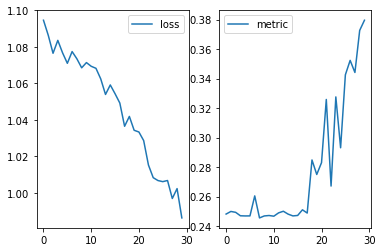

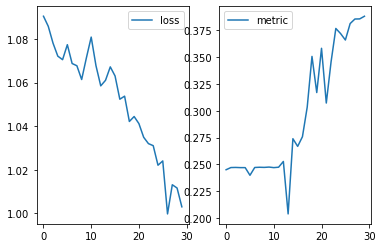

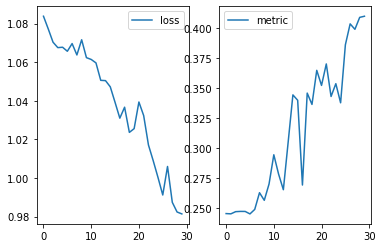

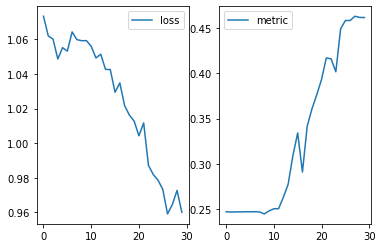

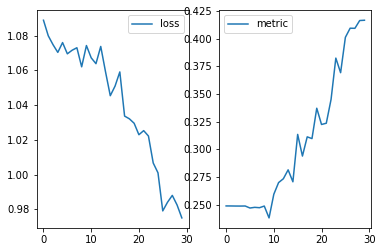

In [32]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()

for fold in range(start_fold, start_fold + num_folds):

    
    model = UNet(
    spatial_dims=3,
    in_channels=1,
    # With softmax 
    out_channels=4,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
    num_res_units=2,
    norm="batch",
    

    )
    model.to(device)
    if load_weights:
            model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))
    
    optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Training Phase 3

In [ ]:
epochs_in_time(time_avail_hrs=5, batch_time_min=3)

In [33]:
#Training settings


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 3
load_weights = True

tr_transforms = train_transforms[0]
batch_size = 8

#tr_transforms = train_transforms[1]
#batch_size = 4

num_epochs = 30
num_folds = 5
start_fold = 0
val_interval = 1
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.CosineAnnealingLR
max_learning_rate = 0.0015
min_learning_rate = 0.001


----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/30  LR=0.0015


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.1179


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.27078092098236084
saved new best metric model
current epoch: 1 current mean dice: 0.2708 best mean dice: 0.2708 at epoch 1
----------
epoch 2/30  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0891


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24685794115066528
current epoch: 2 current mean dice: 0.2469 best mean dice: 0.2708 at epoch 1
----------
epoch 3/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0852


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24919931590557098
current epoch: 3 current mean dice: 0.2492 best mean dice: 0.2708 at epoch 1
----------
epoch 4/30  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0784


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.25052931904792786
current epoch: 4 current mean dice: 0.2505 best mean dice: 0.2708 at epoch 1
----------
epoch 5/30  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0608


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2627309560775757
current epoch: 5 current mean dice: 0.2627 best mean dice: 0.2708 at epoch 1
----------
epoch 6/30  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0637


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24982847273349762
current epoch: 6 current mean dice: 0.2498 best mean dice: 0.2708 at epoch 1
----------
epoch 7/30  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0617


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2884015738964081
saved new best metric model
current epoch: 7 current mean dice: 0.2884 best mean dice: 0.2884 at epoch 7
----------
epoch 8/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0872


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26513200998306274
current epoch: 8 current mean dice: 0.2651 best mean dice: 0.2884 at epoch 7
----------
epoch 9/30  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0760


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2468792200088501
current epoch: 9 current mean dice: 0.2469 best mean dice: 0.2884 at epoch 7
----------
epoch 10/30  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0751


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.24819041788578033
current epoch: 10 current mean dice: 0.2482 best mean dice: 0.2884 at epoch 7
----------
epoch 11/30  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0631


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2819514870643616
current epoch: 11 current mean dice: 0.2820 best mean dice: 0.2884 at epoch 7
----------
epoch 12/30  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0476


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2926158308982849
saved new best metric model
current epoch: 12 current mean dice: 0.2926 best mean dice: 0.2926 at epoch 12
----------
epoch 13/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0525


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.28976577520370483
current epoch: 13 current mean dice: 0.2898 best mean dice: 0.2926 at epoch 12
----------
epoch 14/30  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0481


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33886486291885376
saved new best metric model
current epoch: 14 current mean dice: 0.3389 best mean dice: 0.3389 at epoch 14
----------
epoch 15/30  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0343


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3322061002254486
current epoch: 15 current mean dice: 0.3322 best mean dice: 0.3389 at epoch 14
----------
epoch 16/30  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0175


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.32820141315460205
current epoch: 16 current mean dice: 0.3282 best mean dice: 0.3389 at epoch 14
----------
epoch 17/30  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0250


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37526047229766846
saved new best metric model
current epoch: 17 current mean dice: 0.3753 best mean dice: 0.3753 at epoch 17
----------
epoch 18/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0331


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34852078557014465
current epoch: 18 current mean dice: 0.3485 best mean dice: 0.3753 at epoch 17
----------
epoch 19/30  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0218


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.29652610421180725
current epoch: 19 current mean dice: 0.2965 best mean dice: 0.3753 at epoch 17
----------
epoch 20/30  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0365


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37376418709754944
current epoch: 20 current mean dice: 0.3738 best mean dice: 0.3753 at epoch 17
----------
epoch 21/30  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0212


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4101939797401428
saved new best metric model
current epoch: 21 current mean dice: 0.4102 best mean dice: 0.4102 at epoch 21
----------
epoch 22/30  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0279


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3552056550979614
current epoch: 22 current mean dice: 0.3552 best mean dice: 0.4102 at epoch 21
----------
epoch 23/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0076


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3705419600009918
current epoch: 23 current mean dice: 0.3705 best mean dice: 0.4102 at epoch 21
----------
epoch 24/30  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0121


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4026016592979431
current epoch: 24 current mean dice: 0.4026 best mean dice: 0.4102 at epoch 21
----------
epoch 25/30  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0065


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.43177828192710876
saved new best metric model
current epoch: 25 current mean dice: 0.4318 best mean dice: 0.4318 at epoch 25
----------
epoch 26/30  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0123


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4083757996559143
current epoch: 26 current mean dice: 0.4084 best mean dice: 0.4318 at epoch 25
----------
epoch 27/30  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9929


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4287918210029602
current epoch: 27 current mean dice: 0.4288 best mean dice: 0.4318 at epoch 25
----------
epoch 28/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9898


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.30707183480262756
current epoch: 28 current mean dice: 0.3071 best mean dice: 0.4318 at epoch 25
----------
epoch 29/30  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9917


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4059523046016693
current epoch: 29 current mean dice: 0.4060 best mean dice: 0.4318 at epoch 25
----------
epoch 30/30  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0059


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.35917994379997253
current epoch: 30 current mean dice: 0.3592 best mean dice: 0.4318 at epoch 25
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=0.0015


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0844


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26699477434158325
saved new best metric model
current epoch: 1 current mean dice: 0.2670 best mean dice: 0.2670 at epoch 1
----------
epoch 2/30  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0569


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3126402497291565
saved new best metric model
current epoch: 2 current mean dice: 0.3126 best mean dice: 0.3126 at epoch 2
----------
epoch 3/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0399


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34196195006370544
saved new best metric model
current epoch: 3 current mean dice: 0.3420 best mean dice: 0.3420 at epoch 3
----------
epoch 4/30  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0408


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34220582246780396
saved new best metric model
current epoch: 4 current mean dice: 0.3422 best mean dice: 0.3422 at epoch 4
----------
epoch 5/30  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0437


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2620129883289337
current epoch: 5 current mean dice: 0.2620 best mean dice: 0.3422 at epoch 4
----------
epoch 6/30  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0438


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2671683132648468
current epoch: 6 current mean dice: 0.2672 best mean dice: 0.3422 at epoch 4
----------
epoch 7/30  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0379


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3229884207248688
current epoch: 7 current mean dice: 0.3230 best mean dice: 0.3422 at epoch 4
----------
epoch 8/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0305


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3704424798488617
saved new best metric model
current epoch: 8 current mean dice: 0.3704 best mean dice: 0.3704 at epoch 8
----------
epoch 9/30  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0401


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.35472676157951355
current epoch: 9 current mean dice: 0.3547 best mean dice: 0.3704 at epoch 8
----------
epoch 10/30  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0408


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3624241352081299
current epoch: 10 current mean dice: 0.3624 best mean dice: 0.3704 at epoch 8
----------
epoch 11/30  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0239


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3476640284061432
current epoch: 11 current mean dice: 0.3477 best mean dice: 0.3704 at epoch 8
----------
epoch 12/30  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0237


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37906697392463684
saved new best metric model
current epoch: 12 current mean dice: 0.3791 best mean dice: 0.3791 at epoch 12
----------
epoch 13/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0300


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.343685120344162
current epoch: 13 current mean dice: 0.3437 best mean dice: 0.3791 at epoch 12
----------
epoch 14/30  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0115


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37647709250450134
current epoch: 14 current mean dice: 0.3765 best mean dice: 0.3791 at epoch 12
----------
epoch 15/30  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0391


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3745031952857971
current epoch: 15 current mean dice: 0.3745 best mean dice: 0.3791 at epoch 12
----------
epoch 16/30  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0386


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34257107973098755
current epoch: 16 current mean dice: 0.3426 best mean dice: 0.3791 at epoch 12
----------
epoch 17/30  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0294


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37854158878326416
current epoch: 17 current mean dice: 0.3785 best mean dice: 0.3791 at epoch 12
----------
epoch 18/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0283


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3344945013523102
current epoch: 18 current mean dice: 0.3345 best mean dice: 0.3791 at epoch 12
----------
epoch 19/30  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0283


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.30951252579689026
current epoch: 19 current mean dice: 0.3095 best mean dice: 0.3791 at epoch 12
----------
epoch 20/30  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0157


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3834265172481537
saved new best metric model
current epoch: 20 current mean dice: 0.3834 best mean dice: 0.3834 at epoch 20
----------
epoch 21/30  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0193


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3522760570049286
current epoch: 21 current mean dice: 0.3523 best mean dice: 0.3834 at epoch 20
----------
epoch 22/30  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0417


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.350969135761261
current epoch: 22 current mean dice: 0.3510 best mean dice: 0.3834 at epoch 20
----------
epoch 23/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0335


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3663872480392456
current epoch: 23 current mean dice: 0.3664 best mean dice: 0.3834 at epoch 20
----------
epoch 24/30  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0208


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.27331992983818054
current epoch: 24 current mean dice: 0.2733 best mean dice: 0.3834 at epoch 20
----------
epoch 25/30  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0170


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3865605294704437
saved new best metric model
current epoch: 25 current mean dice: 0.3866 best mean dice: 0.3866 at epoch 25
----------
epoch 26/30  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0125


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.42514780163764954
saved new best metric model
current epoch: 26 current mean dice: 0.4251 best mean dice: 0.4251 at epoch 26
----------
epoch 27/30  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0046


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3762308955192566
current epoch: 27 current mean dice: 0.3762 best mean dice: 0.4251 at epoch 26
----------
epoch 28/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0262


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33705011010169983
current epoch: 28 current mean dice: 0.3371 best mean dice: 0.4251 at epoch 26
----------
epoch 29/30  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0152


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.29968956112861633
current epoch: 29 current mean dice: 0.2997 best mean dice: 0.4251 at epoch 26
----------
epoch 30/30  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0149


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3514450490474701
current epoch: 30 current mean dice: 0.3514 best mean dice: 0.4251 at epoch 26
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=0.0015


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0722


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3433893322944641
saved new best metric model
current epoch: 1 current mean dice: 0.3434 best mean dice: 0.3434 at epoch 1
----------
epoch 2/30  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0625


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.31195077300071716
current epoch: 2 current mean dice: 0.3120 best mean dice: 0.3434 at epoch 1
----------
epoch 3/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0520


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.264807790517807
current epoch: 3 current mean dice: 0.2648 best mean dice: 0.3434 at epoch 1
----------
epoch 4/30  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0312


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.31927645206451416
current epoch: 4 current mean dice: 0.3193 best mean dice: 0.3434 at epoch 1
----------
epoch 5/30  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0476


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3430994153022766
current epoch: 5 current mean dice: 0.3431 best mean dice: 0.3434 at epoch 1
----------
epoch 6/30  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0434


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3418457508087158
current epoch: 6 current mean dice: 0.3418 best mean dice: 0.3434 at epoch 1
----------
epoch 7/30  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0248


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33686724305152893
current epoch: 7 current mean dice: 0.3369 best mean dice: 0.3434 at epoch 1
----------
epoch 8/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0428


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3157047927379608
current epoch: 8 current mean dice: 0.3157 best mean dice: 0.3434 at epoch 1
----------
epoch 9/30  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0316


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2701815664768219
current epoch: 9 current mean dice: 0.2702 best mean dice: 0.3434 at epoch 1
----------
epoch 10/30  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0354


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3248610496520996
current epoch: 10 current mean dice: 0.3249 best mean dice: 0.3434 at epoch 1
----------
epoch 11/30  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0340


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3694930672645569
saved new best metric model
current epoch: 11 current mean dice: 0.3695 best mean dice: 0.3695 at epoch 11
----------
epoch 12/30  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0298


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3383926451206207
current epoch: 12 current mean dice: 0.3384 best mean dice: 0.3695 at epoch 11
----------
epoch 13/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0249


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3919045329093933
saved new best metric model
current epoch: 13 current mean dice: 0.3919 best mean dice: 0.3919 at epoch 13
----------
epoch 14/30  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0121


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3768257796764374
current epoch: 14 current mean dice: 0.3768 best mean dice: 0.3919 at epoch 13
----------
epoch 15/30  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0363


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37153691053390503
current epoch: 15 current mean dice: 0.3715 best mean dice: 0.3919 at epoch 13
----------
epoch 16/30  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0122


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3727909028530121
current epoch: 16 current mean dice: 0.3728 best mean dice: 0.3919 at epoch 13
----------
epoch 17/30  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0066


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3545646369457245
current epoch: 17 current mean dice: 0.3546 best mean dice: 0.3919 at epoch 13
----------
epoch 18/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0123


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4248616695404053
saved new best metric model
current epoch: 18 current mean dice: 0.4249 best mean dice: 0.4249 at epoch 18
----------
epoch 19/30  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 0.9909


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4018341302871704
current epoch: 19 current mean dice: 0.4018 best mean dice: 0.4249 at epoch 18
----------
epoch 20/30  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 0.9992


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33677011728286743
current epoch: 20 current mean dice: 0.3368 best mean dice: 0.4249 at epoch 18
----------
epoch 21/30  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 0.9853


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.39576077461242676
current epoch: 21 current mean dice: 0.3958 best mean dice: 0.4249 at epoch 18
----------
epoch 22/30  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 0.9886


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4376666247844696
saved new best metric model
current epoch: 22 current mean dice: 0.4377 best mean dice: 0.4377 at epoch 22
----------
epoch 23/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 0.9889


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.41626420617103577
current epoch: 23 current mean dice: 0.4163 best mean dice: 0.4377 at epoch 22
----------
epoch 24/30  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0005


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.37695327401161194
current epoch: 24 current mean dice: 0.3770 best mean dice: 0.4377 at epoch 22
----------
epoch 25/30  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9837


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.36799150705337524
current epoch: 25 current mean dice: 0.3680 best mean dice: 0.4377 at epoch 22
----------
epoch 26/30  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9904


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4598710536956787
saved new best metric model
current epoch: 26 current mean dice: 0.4599 best mean dice: 0.4599 at epoch 26
----------
epoch 27/30  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9790


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4797166883945465
saved new best metric model
current epoch: 27 current mean dice: 0.4797 best mean dice: 0.4797 at epoch 27
----------
epoch 28/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9754


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4720667004585266
current epoch: 28 current mean dice: 0.4721 best mean dice: 0.4797 at epoch 27
----------
epoch 29/30  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9682


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4633200168609619
current epoch: 29 current mean dice: 0.4633 best mean dice: 0.4797 at epoch 27
----------
epoch 30/30  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9994


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4500051438808441
current epoch: 30 current mean dice: 0.4500 best mean dice: 0.4797 at epoch 27
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=0.0015


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.1199


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.27305418252944946
saved new best metric model
current epoch: 1 current mean dice: 0.2731 best mean dice: 0.2731 at epoch 1
----------
epoch 2/30  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0582


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.30980321764945984
saved new best metric model
current epoch: 2 current mean dice: 0.3098 best mean dice: 0.3098 at epoch 2
----------
epoch 3/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0484


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.274533748626709
current epoch: 3 current mean dice: 0.2745 best mean dice: 0.3098 at epoch 2
----------
epoch 4/30  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0332


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33373910188674927
saved new best metric model
current epoch: 4 current mean dice: 0.3337 best mean dice: 0.3337 at epoch 4
----------
epoch 5/30  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0351


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.357970267534256
saved new best metric model
current epoch: 5 current mean dice: 0.3580 best mean dice: 0.3580 at epoch 5
----------
epoch 6/30  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0397


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3495016396045685
current epoch: 6 current mean dice: 0.3495 best mean dice: 0.3580 at epoch 5
----------
epoch 7/30  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0311


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3658839166164398
saved new best metric model
current epoch: 7 current mean dice: 0.3659 best mean dice: 0.3659 at epoch 7
----------
epoch 8/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0465


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2765571177005768
current epoch: 8 current mean dice: 0.2766 best mean dice: 0.3659 at epoch 7
----------
epoch 9/30  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0239


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2690056264400482
current epoch: 9 current mean dice: 0.2690 best mean dice: 0.3659 at epoch 7
----------
epoch 10/30  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0663


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3406570851802826
current epoch: 10 current mean dice: 0.3407 best mean dice: 0.3659 at epoch 7
----------
epoch 11/30  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0252


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3172556459903717
current epoch: 11 current mean dice: 0.3173 best mean dice: 0.3659 at epoch 7
----------
epoch 12/30  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0127


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3972446024417877
saved new best metric model
current epoch: 12 current mean dice: 0.3972 best mean dice: 0.3972 at epoch 12
----------
epoch 13/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0292


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2880999445915222
current epoch: 13 current mean dice: 0.2881 best mean dice: 0.3972 at epoch 12
----------
epoch 14/30  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0255


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33193984627723694
current epoch: 14 current mean dice: 0.3319 best mean dice: 0.3972 at epoch 12
----------
epoch 15/30  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0057


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4146171510219574
saved new best metric model
current epoch: 15 current mean dice: 0.4146 best mean dice: 0.4146 at epoch 15
----------
epoch 16/30  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0283


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34261584281921387
current epoch: 16 current mean dice: 0.3426 best mean dice: 0.4146 at epoch 15
----------
epoch 17/30  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0199


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.39723125100135803
current epoch: 17 current mean dice: 0.3972 best mean dice: 0.4146 at epoch 15
----------
epoch 18/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0024


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.36505740880966187
current epoch: 18 current mean dice: 0.3651 best mean dice: 0.4146 at epoch 15
----------
epoch 19/30  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0037


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.44389694929122925
saved new best metric model
current epoch: 19 current mean dice: 0.4439 best mean dice: 0.4439 at epoch 19
----------
epoch 20/30  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 0.9926


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.42351388931274414
current epoch: 20 current mean dice: 0.4235 best mean dice: 0.4439 at epoch 19
----------
epoch 21/30  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0277


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3886813223361969
current epoch: 21 current mean dice: 0.3887 best mean dice: 0.4439 at epoch 19
----------
epoch 22/30  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 0.9957


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.35643404722213745
current epoch: 22 current mean dice: 0.3564 best mean dice: 0.4439 at epoch 19
----------
epoch 23/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0045


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3770281672477722
current epoch: 23 current mean dice: 0.3770 best mean dice: 0.4439 at epoch 19
----------
epoch 24/30  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 0.9918


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4438045918941498
current epoch: 24 current mean dice: 0.4438 best mean dice: 0.4439 at epoch 19
----------
epoch 25/30  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9905


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.43415942788124084
current epoch: 25 current mean dice: 0.4342 best mean dice: 0.4439 at epoch 19
----------
epoch 26/30  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0150


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.45862919092178345
saved new best metric model
current epoch: 26 current mean dice: 0.4586 best mean dice: 0.4586 at epoch 26
----------
epoch 27/30  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9873


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4336991608142853
current epoch: 27 current mean dice: 0.4337 best mean dice: 0.4586 at epoch 26
----------
epoch 28/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9582


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.428501695394516
current epoch: 28 current mean dice: 0.4285 best mean dice: 0.4586 at epoch 26
----------
epoch 29/30  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9698


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4188239276409149
current epoch: 29 current mean dice: 0.4188 best mean dice: 0.4586 at epoch 26
----------
epoch 30/30  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9866


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4852682054042816
saved new best metric model
current epoch: 30 current mean dice: 0.4853 best mean dice: 0.4853 at epoch 30
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/30  LR=0.0015


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0899


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.20270825922489166
saved new best metric model
current epoch: 1 current mean dice: 0.2027 best mean dice: 0.2027 at epoch 1
----------
epoch 2/30  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0499


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.30306947231292725
saved new best metric model
current epoch: 2 current mean dice: 0.3031 best mean dice: 0.3031 at epoch 2
----------
epoch 3/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0434


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2772330343723297
current epoch: 3 current mean dice: 0.2772 best mean dice: 0.3031 at epoch 2
----------
epoch 4/30  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0378


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3105509579181671
saved new best metric model
current epoch: 4 current mean dice: 0.3106 best mean dice: 0.3106 at epoch 4
----------
epoch 5/30  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0436


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.30182766914367676
current epoch: 5 current mean dice: 0.3018 best mean dice: 0.3106 at epoch 4
----------
epoch 6/30  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0433


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3052646219730377
current epoch: 6 current mean dice: 0.3053 best mean dice: 0.3106 at epoch 4
----------
epoch 7/30  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0376


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.32295942306518555
saved new best metric model
current epoch: 7 current mean dice: 0.3230 best mean dice: 0.3230 at epoch 7
----------
epoch 8/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0364


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.31724095344543457
current epoch: 8 current mean dice: 0.3172 best mean dice: 0.3230 at epoch 7
----------
epoch 9/30  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0345


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3080996572971344
current epoch: 9 current mean dice: 0.3081 best mean dice: 0.3230 at epoch 7
----------
epoch 10/30  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0357


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2703923285007477
current epoch: 10 current mean dice: 0.2704 best mean dice: 0.3230 at epoch 7
----------
epoch 11/30  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0460


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3511318564414978
saved new best metric model
current epoch: 11 current mean dice: 0.3511 best mean dice: 0.3511 at epoch 11
----------
epoch 12/30  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0266


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.342190682888031
current epoch: 12 current mean dice: 0.3422 best mean dice: 0.3511 at epoch 11
----------
epoch 13/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0311


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34919115900993347
current epoch: 13 current mean dice: 0.3492 best mean dice: 0.3511 at epoch 11
----------
epoch 14/30  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0416


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3429395854473114
current epoch: 14 current mean dice: 0.3429 best mean dice: 0.3511 at epoch 11
----------
epoch 15/30  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0206


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.36483222246170044
saved new best metric model
current epoch: 15 current mean dice: 0.3648 best mean dice: 0.3648 at epoch 15
----------
epoch 16/30  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0123


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.34355607628822327
current epoch: 16 current mean dice: 0.3436 best mean dice: 0.3648 at epoch 15
----------
epoch 17/30  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0169


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.39061200618743896
saved new best metric model
current epoch: 17 current mean dice: 0.3906 best mean dice: 0.3906 at epoch 17
----------
epoch 18/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 0.9973


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.381837397813797
current epoch: 18 current mean dice: 0.3818 best mean dice: 0.3906 at epoch 17
----------
epoch 19/30  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0334


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3425261676311493
current epoch: 19 current mean dice: 0.3425 best mean dice: 0.3906 at epoch 17
----------
epoch 20/30  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0148


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3240593671798706
current epoch: 20 current mean dice: 0.3241 best mean dice: 0.3906 at epoch 17
----------
epoch 21/30  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0021


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3603818118572235
current epoch: 21 current mean dice: 0.3604 best mean dice: 0.3906 at epoch 17
----------
epoch 22/30  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0004


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4401243031024933
saved new best metric model
current epoch: 22 current mean dice: 0.4401 best mean dice: 0.4401 at epoch 22
----------
epoch 23/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0042


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.36534515023231506
current epoch: 23 current mean dice: 0.3653 best mean dice: 0.4401 at epoch 22
----------
epoch 24/30  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0111


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3110208213329315
current epoch: 24 current mean dice: 0.3110 best mean dice: 0.4401 at epoch 22
----------
epoch 25/30  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0175


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3476122319698334
current epoch: 25 current mean dice: 0.3476 best mean dice: 0.4401 at epoch 22
----------
epoch 26/30  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9970


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.39887964725494385
current epoch: 26 current mean dice: 0.3989 best mean dice: 0.4401 at epoch 22
----------
epoch 27/30  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9979


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3784336447715759
current epoch: 27 current mean dice: 0.3784 best mean dice: 0.4401 at epoch 22
----------
epoch 28/30  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9729


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4743712544441223
saved new best metric model
current epoch: 28 current mean dice: 0.4744 best mean dice: 0.4744 at epoch 28
----------
epoch 29/30  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9711


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3758949339389801
current epoch: 29 current mean dice: 0.3759 best mean dice: 0.4744 at epoch 28
----------
epoch 30/30  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9754


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49890264868736267
saved new best metric model
current epoch: 30 current mean dice: 0.4989 best mean dice: 0.4989 at epoch 30


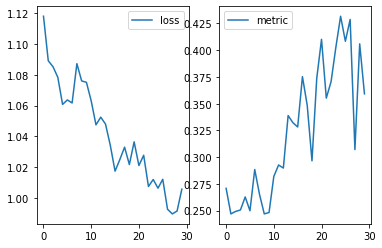

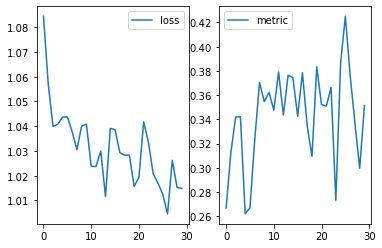

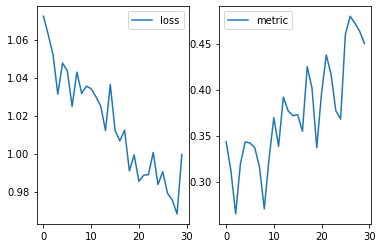

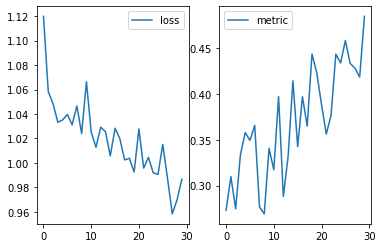

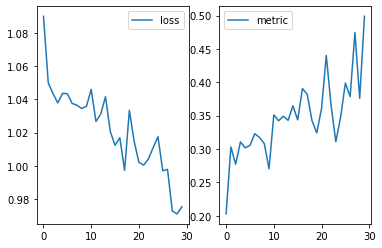

In [35]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()

for fold in range(start_fold, start_fold + num_folds):

    
    model = UNet(
    spatial_dims=3,
    in_channels=1,
    # With softmax 
    out_channels=4,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
    num_res_units=2,
    norm="batch",
    

    )
    model.to(device)
    if load_weights:
            model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))
    
    optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    #lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    lr_scheduler = LR(optimizer, T_max=5, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Training phase 4
Training the same model with all the folds to speed up training time

In [25]:
#Training settings  Note that this is meant to train the same model with each fold!


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 4
load_weights = True
fold = 4 # Provide fold to load initially

tr_transforms = train_transforms[0]
batch_size = 8

#tr_transforms = train_transforms[1]
#batch_size = 4

num_epochs = 40
num_folds = 5
start_fold = 0
val_interval = 1
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.CosineAnnealingLR
max_learning_rate = 0.0015
min_learning_rate = 0.001

----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/40  LR=0.0015


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0031


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3766023814678192
saved new best metric model
current epoch: 1 current mean dice: 0.3766 best mean dice: 0.3766 at epoch 1
----------
epoch 2/40  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 0.9787


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.45777595043182373
saved new best metric model
current epoch: 2 current mean dice: 0.4578 best mean dice: 0.4578 at epoch 2
----------
epoch 3/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 0.9921


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.21659789979457855
current epoch: 3 current mean dice: 0.2166 best mean dice: 0.4578 at epoch 2
----------
epoch 4/40  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 0.9945


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.29668232798576355
current epoch: 4 current mean dice: 0.2967 best mean dice: 0.4578 at epoch 2
----------
epoch 5/40  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0006


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.36220601201057434
current epoch: 5 current mean dice: 0.3622 best mean dice: 0.4578 at epoch 2
----------
epoch 6/40  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0069


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49534547328948975
saved new best metric model
current epoch: 6 current mean dice: 0.4953 best mean dice: 0.4953 at epoch 6
----------
epoch 7/40  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 0.9850


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.46033400297164917
current epoch: 7 current mean dice: 0.4603 best mean dice: 0.4953 at epoch 6
----------
epoch 8/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 0.9815


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4034625291824341
current epoch: 8 current mean dice: 0.4035 best mean dice: 0.4953 at epoch 6
----------
epoch 9/40  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 0.9723


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4987333118915558
saved new best metric model
current epoch: 9 current mean dice: 0.4987 best mean dice: 0.4987 at epoch 9
----------
epoch 10/40  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 0.9940


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3195898234844208
current epoch: 10 current mean dice: 0.3196 best mean dice: 0.4987 at epoch 9
----------
epoch 11/40  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 0.9636


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4947572648525238
current epoch: 11 current mean dice: 0.4948 best mean dice: 0.4987 at epoch 9
----------
epoch 12/40  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0082


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.42176353931427
current epoch: 12 current mean dice: 0.4218 best mean dice: 0.4987 at epoch 9
----------
epoch 13/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 0.9818


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5237600803375244
saved new best metric model
current epoch: 13 current mean dice: 0.5238 best mean dice: 0.5238 at epoch 13
----------
epoch 14/40  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 0.9891


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3730558454990387
current epoch: 14 current mean dice: 0.3731 best mean dice: 0.5238 at epoch 13
----------
epoch 15/40  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 0.9808


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5058762431144714
current epoch: 15 current mean dice: 0.5059 best mean dice: 0.5238 at epoch 13
----------
epoch 16/40  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 0.9548


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5003556609153748
current epoch: 16 current mean dice: 0.5004 best mean dice: 0.5238 at epoch 13
----------
epoch 17/40  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 0.9773


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4620274007320404
current epoch: 17 current mean dice: 0.4620 best mean dice: 0.5238 at epoch 13
----------
epoch 18/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 0.9796


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5234658122062683
current epoch: 18 current mean dice: 0.5235 best mean dice: 0.5238 at epoch 13
----------
epoch 19/40  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 0.9676


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.502626359462738
current epoch: 19 current mean dice: 0.5026 best mean dice: 0.5238 at epoch 13
----------
epoch 20/40  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 0.9764


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49790656566619873
current epoch: 20 current mean dice: 0.4979 best mean dice: 0.5238 at epoch 13
----------
epoch 21/40  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 0.9626


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49632933735847473
current epoch: 21 current mean dice: 0.4963 best mean dice: 0.5238 at epoch 13
----------
epoch 22/40  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 0.9697


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5265774726867676
saved new best metric model
current epoch: 22 current mean dice: 0.5266 best mean dice: 0.5266 at epoch 22
----------
epoch 23/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 0.9614


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4548984169960022
current epoch: 23 current mean dice: 0.4549 best mean dice: 0.5266 at epoch 22
----------
epoch 24/40  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 0.9565


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.41673386096954346
current epoch: 24 current mean dice: 0.4167 best mean dice: 0.5266 at epoch 22
----------
epoch 25/40  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9444


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5023363828659058
current epoch: 25 current mean dice: 0.5023 best mean dice: 0.5266 at epoch 22
----------
epoch 26/40  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9530


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5079028010368347
current epoch: 26 current mean dice: 0.5079 best mean dice: 0.5266 at epoch 22
----------
epoch 27/40  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9700


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.48973947763442993
current epoch: 27 current mean dice: 0.4897 best mean dice: 0.5266 at epoch 22
----------
epoch 28/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9576


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4278255105018616
current epoch: 28 current mean dice: 0.4278 best mean dice: 0.5266 at epoch 22
----------
epoch 29/40  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9499


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4644075930118561
current epoch: 29 current mean dice: 0.4644 best mean dice: 0.5266 at epoch 22
----------
epoch 30/40  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9402


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5014266967773438
current epoch: 30 current mean dice: 0.5014 best mean dice: 0.5266 at epoch 22
----------
epoch 31/40  LR=0.0015000000000000107


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 0.9686


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5568810105323792
saved new best metric model
current epoch: 31 current mean dice: 0.5569 best mean dice: 0.5569 at epoch 31
----------
epoch 32/40  LR=0.0013272542485936927


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 0.9586


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.41497427225112915
current epoch: 32 current mean dice: 0.4150 best mean dice: 0.5569 at epoch 31
----------
epoch 33/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 0.9492


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5073959827423096
current epoch: 33 current mean dice: 0.5074 best mean dice: 0.5569 at epoch 31
----------
epoch 34/40  LR=0.0010477457514062782


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 0.9421


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.44335615634918213
current epoch: 34 current mean dice: 0.4434 best mean dice: 0.5569 at epoch 31
----------
epoch 35/40  LR=0.0013272542485937662


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 0.9423


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5102985501289368
current epoch: 35 current mean dice: 0.5103 best mean dice: 0.5569 at epoch 31
----------
epoch 36/40  LR=0.00149999999999995


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 0.9720


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3410637378692627
current epoch: 36 current mean dice: 0.3411 best mean dice: 0.5569 at epoch 31
----------
epoch 37/40  LR=0.001327254248593777


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 0.9605


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.44971317052841187
current epoch: 37 current mean dice: 0.4497 best mean dice: 0.5569 at epoch 31
----------
epoch 38/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 0.9633


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.42992326617240906
current epoch: 38 current mean dice: 0.4299 best mean dice: 0.5569 at epoch 31
----------
epoch 39/40  LR=0.0010477457514062667


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 0.9468


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5448839664459229
current epoch: 39 current mean dice: 0.5449 best mean dice: 0.5569 at epoch 31
----------
epoch 40/40  LR=0.0013272542485937174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 0.9524


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5011423826217651
current epoch: 40 current mean dice: 0.5011 best mean dice: 0.5569 at epoch 31
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001500000000000065


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 0.9387


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5689905285835266
saved new best metric model
current epoch: 1 current mean dice: 0.5690 best mean dice: 0.5690 at epoch 1
----------
epoch 2/40  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 0.9712


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5111538767814636
current epoch: 2 current mean dice: 0.5112 best mean dice: 0.5690 at epoch 1
----------
epoch 3/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 0.9523


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5271440148353577
current epoch: 3 current mean dice: 0.5271 best mean dice: 0.5690 at epoch 1
----------
epoch 4/40  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 0.9358


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3337482810020447
current epoch: 4 current mean dice: 0.3337 best mean dice: 0.5690 at epoch 1
----------
epoch 5/40  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 0.9701


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.39208704233169556
current epoch: 5 current mean dice: 0.3921 best mean dice: 0.5690 at epoch 1
----------
epoch 6/40  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 0.9796


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.35431352257728577
current epoch: 6 current mean dice: 0.3543 best mean dice: 0.5690 at epoch 1
----------
epoch 7/40  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 0.9767


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.527418315410614
current epoch: 7 current mean dice: 0.5274 best mean dice: 0.5690 at epoch 1
----------
epoch 8/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 0.9726


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.2767081558704376
current epoch: 8 current mean dice: 0.2767 best mean dice: 0.5690 at epoch 1
----------
epoch 9/40  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0080


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4549880921840668
current epoch: 9 current mean dice: 0.4550 best mean dice: 0.5690 at epoch 1
----------
epoch 10/40  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 0.9548


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49301308393478394
current epoch: 10 current mean dice: 0.4930 best mean dice: 0.5690 at epoch 1
----------
epoch 11/40  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 0.9533


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5289395451545715
current epoch: 11 current mean dice: 0.5289 best mean dice: 0.5690 at epoch 1
----------
epoch 12/40  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 0.9394


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.471172958612442
current epoch: 12 current mean dice: 0.4712 best mean dice: 0.5690 at epoch 1
----------
epoch 13/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 0.9484


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5397617816925049
current epoch: 13 current mean dice: 0.5398 best mean dice: 0.5690 at epoch 1
----------
epoch 14/40  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 0.9489


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.43972039222717285
current epoch: 14 current mean dice: 0.4397 best mean dice: 0.5690 at epoch 1
----------
epoch 15/40  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 0.9257


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5265381932258606
current epoch: 15 current mean dice: 0.5265 best mean dice: 0.5690 at epoch 1
----------
epoch 16/40  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 0.9237


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.48831427097320557
current epoch: 16 current mean dice: 0.4883 best mean dice: 0.5690 at epoch 1
----------
epoch 17/40  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 0.9507


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.38609910011291504
current epoch: 17 current mean dice: 0.3861 best mean dice: 0.5690 at epoch 1
----------
epoch 18/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 0.9460


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.467752069234848
current epoch: 18 current mean dice: 0.4678 best mean dice: 0.5690 at epoch 1
----------
epoch 19/40  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 0.9497


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49048981070518494
current epoch: 19 current mean dice: 0.4905 best mean dice: 0.5690 at epoch 1
----------
epoch 20/40  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 0.9392


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4925040602684021
current epoch: 20 current mean dice: 0.4925 best mean dice: 0.5690 at epoch 1
----------
epoch 21/40  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 0.9331


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5764883756637573
saved new best metric model
current epoch: 21 current mean dice: 0.5765 best mean dice: 0.5765 at epoch 21
----------
epoch 22/40  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 0.9347


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5543515086174011
current epoch: 22 current mean dice: 0.5544 best mean dice: 0.5765 at epoch 21
----------
epoch 23/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 0.9395


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5259169936180115
current epoch: 23 current mean dice: 0.5259 best mean dice: 0.5765 at epoch 21
----------
epoch 24/40  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 0.9479


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4318949282169342
current epoch: 24 current mean dice: 0.4319 best mean dice: 0.5765 at epoch 21
----------
epoch 25/40  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9212


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5098784565925598
current epoch: 25 current mean dice: 0.5099 best mean dice: 0.5765 at epoch 21
----------
epoch 26/40  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9363


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5359407663345337
current epoch: 26 current mean dice: 0.5359 best mean dice: 0.5765 at epoch 21
----------
epoch 27/40  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9378


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5947215557098389
saved new best metric model
current epoch: 27 current mean dice: 0.5947 best mean dice: 0.5947 at epoch 27
----------
epoch 28/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9183


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4140317142009735
current epoch: 28 current mean dice: 0.4140 best mean dice: 0.5947 at epoch 27
----------
epoch 29/40  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9622


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3896888792514801
current epoch: 29 current mean dice: 0.3897 best mean dice: 0.5947 at epoch 27
----------
epoch 30/40  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9300


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5684419274330139
current epoch: 30 current mean dice: 0.5684 best mean dice: 0.5947 at epoch 27
----------
epoch 31/40  LR=0.0015000000000000107


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 0.9393


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5827347636222839
current epoch: 31 current mean dice: 0.5827 best mean dice: 0.5947 at epoch 27
----------
epoch 32/40  LR=0.0013272542485936927


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 0.9444


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5980339050292969
saved new best metric model
current epoch: 32 current mean dice: 0.5980 best mean dice: 0.5980 at epoch 32
----------
epoch 33/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 0.9291


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5269880890846252
current epoch: 33 current mean dice: 0.5270 best mean dice: 0.5980 at epoch 32
----------
epoch 34/40  LR=0.0010477457514062782


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 0.9145


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5187775492668152
current epoch: 34 current mean dice: 0.5188 best mean dice: 0.5980 at epoch 32
----------
epoch 35/40  LR=0.0013272542485937662


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 0.8996


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5375701785087585
current epoch: 35 current mean dice: 0.5376 best mean dice: 0.5980 at epoch 32
----------
epoch 36/40  LR=0.00149999999999995


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 0.9429


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5831917524337769
current epoch: 36 current mean dice: 0.5832 best mean dice: 0.5980 at epoch 32
----------
epoch 37/40  LR=0.001327254248593777


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 0.9097


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.525920033454895
current epoch: 37 current mean dice: 0.5259 best mean dice: 0.5980 at epoch 32
----------
epoch 38/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 0.9102


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.555260181427002
current epoch: 38 current mean dice: 0.5553 best mean dice: 0.5980 at epoch 32
----------
epoch 39/40  LR=0.0010477457514062667


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 0.9328


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5054610371589661
current epoch: 39 current mean dice: 0.5055 best mean dice: 0.5980 at epoch 32
----------
epoch 40/40  LR=0.0013272542485937174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 0.9268


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5302894711494446
current epoch: 40 current mean dice: 0.5303 best mean dice: 0.5980 at epoch 32
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001500000000000065


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 0.9257


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5937774777412415
saved new best metric model
current epoch: 1 current mean dice: 0.5938 best mean dice: 0.5938 at epoch 1
----------
epoch 2/40  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 0.9245


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5895096063613892
current epoch: 2 current mean dice: 0.5895 best mean dice: 0.5938 at epoch 1
----------
epoch 3/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 0.9107


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5738922357559204
current epoch: 3 current mean dice: 0.5739 best mean dice: 0.5938 at epoch 1
----------
epoch 4/40  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 0.9058


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.531354546546936
current epoch: 4 current mean dice: 0.5314 best mean dice: 0.5938 at epoch 1
----------
epoch 5/40  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 0.9009


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6253984570503235
saved new best metric model
current epoch: 5 current mean dice: 0.6254 best mean dice: 0.6254 at epoch 5
----------
epoch 6/40  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 0.9404


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.505318820476532
current epoch: 6 current mean dice: 0.5053 best mean dice: 0.6254 at epoch 5
----------
epoch 7/40  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 0.9215


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5855550169944763
current epoch: 7 current mean dice: 0.5856 best mean dice: 0.6254 at epoch 5
----------
epoch 8/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 0.9141


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5381535887718201
current epoch: 8 current mean dice: 0.5382 best mean dice: 0.6254 at epoch 5
----------
epoch 9/40  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 0.9022


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5025748014450073
current epoch: 9 current mean dice: 0.5026 best mean dice: 0.6254 at epoch 5
----------
epoch 10/40  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 0.9428


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5775550007820129
current epoch: 10 current mean dice: 0.5776 best mean dice: 0.6254 at epoch 5
----------
epoch 11/40  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 0.9050


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.644936740398407
saved new best metric model
current epoch: 11 current mean dice: 0.6449 best mean dice: 0.6449 at epoch 11
----------
epoch 12/40  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 0.9076


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6408751010894775
current epoch: 12 current mean dice: 0.6409 best mean dice: 0.6449 at epoch 11
----------
epoch 13/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 0.9132


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5463328957557678
current epoch: 13 current mean dice: 0.5463 best mean dice: 0.6449 at epoch 11
----------
epoch 14/40  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 0.9226


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6011785268783569
current epoch: 14 current mean dice: 0.6012 best mean dice: 0.6449 at epoch 11
----------
epoch 15/40  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 0.8956


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6254075765609741
current epoch: 15 current mean dice: 0.6254 best mean dice: 0.6449 at epoch 11
----------
epoch 16/40  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 0.9242


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6500088572502136
saved new best metric model
current epoch: 16 current mean dice: 0.6500 best mean dice: 0.6500 at epoch 16
----------
epoch 17/40  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 0.9224


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5997337102890015
current epoch: 17 current mean dice: 0.5997 best mean dice: 0.6500 at epoch 16
----------
epoch 18/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 0.8935


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6187906861305237
current epoch: 18 current mean dice: 0.6188 best mean dice: 0.6500 at epoch 16
----------
epoch 19/40  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 0.9172


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5959383845329285
current epoch: 19 current mean dice: 0.5959 best mean dice: 0.6500 at epoch 16
----------
epoch 20/40  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 0.8926


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5919393301010132
current epoch: 20 current mean dice: 0.5919 best mean dice: 0.6500 at epoch 16
----------
epoch 21/40  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 0.8954


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6337867975234985
current epoch: 21 current mean dice: 0.6338 best mean dice: 0.6500 at epoch 16
----------
epoch 22/40  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 0.9078


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5218356251716614
current epoch: 22 current mean dice: 0.5218 best mean dice: 0.6500 at epoch 16
----------
epoch 23/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 0.9016


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.652532696723938
saved new best metric model
current epoch: 23 current mean dice: 0.6525 best mean dice: 0.6525 at epoch 23
----------
epoch 24/40  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 0.9279


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4430569112300873
current epoch: 24 current mean dice: 0.4431 best mean dice: 0.6525 at epoch 23
----------
epoch 25/40  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9312


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6338086128234863
current epoch: 25 current mean dice: 0.6338 best mean dice: 0.6525 at epoch 23
----------
epoch 26/40  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9015


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5985973477363586
current epoch: 26 current mean dice: 0.5986 best mean dice: 0.6525 at epoch 23
----------
epoch 27/40  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9167


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6241310834884644
current epoch: 27 current mean dice: 0.6241 best mean dice: 0.6525 at epoch 23
----------
epoch 28/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9075


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6409573554992676
current epoch: 28 current mean dice: 0.6410 best mean dice: 0.6525 at epoch 23
----------
epoch 29/40  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.8857


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5601522326469421
current epoch: 29 current mean dice: 0.5602 best mean dice: 0.6525 at epoch 23
----------
epoch 30/40  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9193


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6398265361785889
current epoch: 30 current mean dice: 0.6398 best mean dice: 0.6525 at epoch 23
----------
epoch 31/40  LR=0.0015000000000000107


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 0.8894


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.612706184387207
current epoch: 31 current mean dice: 0.6127 best mean dice: 0.6525 at epoch 23
----------
epoch 32/40  LR=0.0013272542485936927


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 0.8968


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5721453428268433
current epoch: 32 current mean dice: 0.5721 best mean dice: 0.6525 at epoch 23
----------
epoch 33/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 0.9080


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5534094572067261
current epoch: 33 current mean dice: 0.5534 best mean dice: 0.6525 at epoch 23
----------
epoch 34/40  LR=0.0010477457514062782


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 0.9064


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.659777820110321
saved new best metric model
current epoch: 34 current mean dice: 0.6598 best mean dice: 0.6598 at epoch 34
----------
epoch 35/40  LR=0.0013272542485937662


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 0.9182


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5844696164131165
current epoch: 35 current mean dice: 0.5845 best mean dice: 0.6598 at epoch 34
----------
epoch 36/40  LR=0.00149999999999995


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 0.9333


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6002481579780579
current epoch: 36 current mean dice: 0.6002 best mean dice: 0.6598 at epoch 34
----------
epoch 37/40  LR=0.001327254248593777


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 0.9172


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.659672737121582
current epoch: 37 current mean dice: 0.6597 best mean dice: 0.6598 at epoch 34
----------
epoch 38/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 0.9016


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5735034942626953
current epoch: 38 current mean dice: 0.5735 best mean dice: 0.6598 at epoch 34
----------
epoch 39/40  LR=0.0010477457514062667


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 0.9063


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6281394362449646
current epoch: 39 current mean dice: 0.6281 best mean dice: 0.6598 at epoch 34
----------
epoch 40/40  LR=0.0013272542485937174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 0.9009


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6048194169998169
current epoch: 40 current mean dice: 0.6048 best mean dice: 0.6598 at epoch 34
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001500000000000065


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 0.9106


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.619247317314148
saved new best metric model
current epoch: 1 current mean dice: 0.6192 best mean dice: 0.6192 at epoch 1
----------
epoch 2/40  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 0.8812


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6198582649230957
saved new best metric model
current epoch: 2 current mean dice: 0.6199 best mean dice: 0.6199 at epoch 2
----------
epoch 3/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 0.8786


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6886373162269592
saved new best metric model
current epoch: 3 current mean dice: 0.6886 best mean dice: 0.6886 at epoch 3
----------
epoch 4/40  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 0.8895


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.668354332447052
current epoch: 4 current mean dice: 0.6684 best mean dice: 0.6886 at epoch 3
----------
epoch 5/40  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 0.8827


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6496030688285828
current epoch: 5 current mean dice: 0.6496 best mean dice: 0.6886 at epoch 3
----------
epoch 6/40  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 0.8850


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6492318511009216
current epoch: 6 current mean dice: 0.6492 best mean dice: 0.6886 at epoch 3
----------
epoch 7/40  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 0.8849


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6155468821525574
current epoch: 7 current mean dice: 0.6155 best mean dice: 0.6886 at epoch 3
----------
epoch 8/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 0.8834


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6233448386192322
current epoch: 8 current mean dice: 0.6233 best mean dice: 0.6886 at epoch 3
----------
epoch 9/40  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 0.8730


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5711106061935425
current epoch: 9 current mean dice: 0.5711 best mean dice: 0.6886 at epoch 3
----------
epoch 10/40  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 0.9030


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6763697266578674
current epoch: 10 current mean dice: 0.6764 best mean dice: 0.6886 at epoch 3
----------
epoch 11/40  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 0.8641


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6801050305366516
current epoch: 11 current mean dice: 0.6801 best mean dice: 0.6886 at epoch 3
----------
epoch 12/40  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 0.8819


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6655654907226562
current epoch: 12 current mean dice: 0.6656 best mean dice: 0.6886 at epoch 3
----------
epoch 13/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 0.9046


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6382536292076111
current epoch: 13 current mean dice: 0.6383 best mean dice: 0.6886 at epoch 3
----------
epoch 14/40  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 0.8783


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5947347283363342
current epoch: 14 current mean dice: 0.5947 best mean dice: 0.6886 at epoch 3
----------
epoch 15/40  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 0.9088


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6626460552215576
current epoch: 15 current mean dice: 0.6626 best mean dice: 0.6886 at epoch 3
----------
epoch 16/40  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 0.8929


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6255998611450195
current epoch: 16 current mean dice: 0.6256 best mean dice: 0.6886 at epoch 3
----------
epoch 17/40  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 0.9138


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6363148093223572
current epoch: 17 current mean dice: 0.6363 best mean dice: 0.6886 at epoch 3
----------
epoch 18/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 0.8913


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5545494556427002
current epoch: 18 current mean dice: 0.5545 best mean dice: 0.6886 at epoch 3
----------
epoch 19/40  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 0.9151


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5221525430679321
current epoch: 19 current mean dice: 0.5222 best mean dice: 0.6886 at epoch 3
----------
epoch 20/40  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 0.9132


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5555254220962524
current epoch: 20 current mean dice: 0.5555 best mean dice: 0.6886 at epoch 3
----------
epoch 21/40  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 0.9246


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5500676035881042
current epoch: 21 current mean dice: 0.5501 best mean dice: 0.6886 at epoch 3
----------
epoch 22/40  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 0.9130


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5931736826896667
current epoch: 22 current mean dice: 0.5932 best mean dice: 0.6886 at epoch 3
----------
epoch 23/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 0.9129


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5227065086364746
current epoch: 23 current mean dice: 0.5227 best mean dice: 0.6886 at epoch 3
----------
epoch 24/40  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 0.9315


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.42804884910583496
current epoch: 24 current mean dice: 0.4280 best mean dice: 0.6886 at epoch 3
----------
epoch 25/40  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9344


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6095965504646301
current epoch: 25 current mean dice: 0.6096 best mean dice: 0.6886 at epoch 3
----------
epoch 26/40  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9214


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.46991658210754395
current epoch: 26 current mean dice: 0.4699 best mean dice: 0.6886 at epoch 3
----------
epoch 27/40  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.9088


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4952642023563385
current epoch: 27 current mean dice: 0.4953 best mean dice: 0.6886 at epoch 3
----------
epoch 28/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.9122


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6305296421051025
current epoch: 28 current mean dice: 0.6305 best mean dice: 0.6886 at epoch 3
----------
epoch 29/40  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9164


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5837876796722412
current epoch: 29 current mean dice: 0.5838 best mean dice: 0.6886 at epoch 3
----------
epoch 30/40  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.8845


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5537651181221008
current epoch: 30 current mean dice: 0.5538 best mean dice: 0.6886 at epoch 3
----------
epoch 31/40  LR=0.0015000000000000107


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 0.8915


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6068446040153503
current epoch: 31 current mean dice: 0.6068 best mean dice: 0.6886 at epoch 3
----------
epoch 32/40  LR=0.0013272542485936927


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 0.8948


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6348745226860046
current epoch: 32 current mean dice: 0.6349 best mean dice: 0.6886 at epoch 3
----------
epoch 33/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 0.9113


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.45662322640419006
current epoch: 33 current mean dice: 0.4566 best mean dice: 0.6886 at epoch 3
----------
epoch 34/40  LR=0.0010477457514062782


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 0.9083


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6402102112770081
current epoch: 34 current mean dice: 0.6402 best mean dice: 0.6886 at epoch 3
----------
epoch 35/40  LR=0.0013272542485937662


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 0.8971


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5676588416099548
current epoch: 35 current mean dice: 0.5677 best mean dice: 0.6886 at epoch 3
----------
epoch 36/40  LR=0.00149999999999995


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 0.9048


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5884410738945007
current epoch: 36 current mean dice: 0.5884 best mean dice: 0.6886 at epoch 3
----------
epoch 37/40  LR=0.001327254248593777


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 0.9117


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6535569429397583
current epoch: 37 current mean dice: 0.6536 best mean dice: 0.6886 at epoch 3
----------
epoch 38/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 0.8789


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6687699556350708
current epoch: 38 current mean dice: 0.6688 best mean dice: 0.6886 at epoch 3
----------
epoch 39/40  LR=0.0010477457514062667


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 0.8805


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6109294295310974
current epoch: 39 current mean dice: 0.6109 best mean dice: 0.6886 at epoch 3
----------
epoch 40/40  LR=0.0013272542485937174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 0.9076


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6117717623710632
current epoch: 40 current mean dice: 0.6118 best mean dice: 0.6886 at epoch 3
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001500000000000065


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 0.8869


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5248904228210449
saved new best metric model
current epoch: 1 current mean dice: 0.5249 best mean dice: 0.5249 at epoch 1
----------
epoch 2/40  LR=0.001327254248593738


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 0.8981


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5734378695487976
saved new best metric model
current epoch: 2 current mean dice: 0.5734 best mean dice: 0.5734 at epoch 2
----------
epoch 3/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 0.8991


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6010749936103821
saved new best metric model
current epoch: 3 current mean dice: 0.6011 best mean dice: 0.6011 at epoch 3
----------
epoch 4/40  LR=0.0010477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 0.8903


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5857759118080139
current epoch: 4 current mean dice: 0.5858 best mean dice: 0.6011 at epoch 3
----------
epoch 5/40  LR=0.0013272542485937336


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 0.8880


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.33871763944625854
current epoch: 5 current mean dice: 0.3387 best mean dice: 0.6011 at epoch 3
----------
epoch 6/40  LR=0.001500000000000006


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 0.9280


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5876866579055786
current epoch: 6 current mean dice: 0.5877 best mean dice: 0.6011 at epoch 3
----------
epoch 7/40  LR=0.0013272542485937334


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 0.9053


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.66721510887146
saved new best metric model
current epoch: 7 current mean dice: 0.6672 best mean dice: 0.6672 at epoch 7
----------
epoch 8/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 0.8832


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5384083986282349
current epoch: 8 current mean dice: 0.5384 best mean dice: 0.6672 at epoch 7
----------
epoch 9/40  LR=0.0010477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 0.8796


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5312725305557251
current epoch: 9 current mean dice: 0.5313 best mean dice: 0.6672 at epoch 7
----------
epoch 10/40  LR=0.0013272542485937486


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 0.9039


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5511235594749451
current epoch: 10 current mean dice: 0.5511 best mean dice: 0.6672 at epoch 7
----------
epoch 11/40  LR=0.0014999999999999896


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 0.8851


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5555917620658875
current epoch: 11 current mean dice: 0.5556 best mean dice: 0.6672 at epoch 7
----------
epoch 12/40  LR=0.0013272542485937395


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 0.8840


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6026180386543274
current epoch: 12 current mean dice: 0.6026 best mean dice: 0.6672 at epoch 7
----------
epoch 13/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 0.8941


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6767255663871765
saved new best metric model
current epoch: 13 current mean dice: 0.6767 best mean dice: 0.6767 at epoch 13
----------
epoch 14/40  LR=0.0010477457514062659


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 0.8904


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5846389532089233
current epoch: 14 current mean dice: 0.5846 best mean dice: 0.6767 at epoch 13
----------
epoch 15/40  LR=0.0013272542485937493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 0.9022


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5557445883750916
current epoch: 15 current mean dice: 0.5557 best mean dice: 0.6767 at epoch 13
----------
epoch 16/40  LR=0.0015000000000000167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 0.9118


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.544712245464325
current epoch: 16 current mean dice: 0.5447 best mean dice: 0.6767 at epoch 13
----------
epoch 17/40  LR=0.0013272542485937532


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 0.9028


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6848472356796265
saved new best metric model
current epoch: 17 current mean dice: 0.6848 best mean dice: 0.6848 at epoch 17
----------
epoch 18/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 0.8870


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.574442446231842
current epoch: 18 current mean dice: 0.5744 best mean dice: 0.6848 at epoch 17
----------
epoch 19/40  LR=0.0010477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 0.8881


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5951269865036011
current epoch: 19 current mean dice: 0.5951 best mean dice: 0.6848 at epoch 17
----------
epoch 20/40  LR=0.0013272542485937577


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 0.8855


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6777454614639282
current epoch: 20 current mean dice: 0.6777 best mean dice: 0.6848 at epoch 17
----------
epoch 21/40  LR=0.0015000000000000443


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 0.8989


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.572040855884552
current epoch: 21 current mean dice: 0.5720 best mean dice: 0.6848 at epoch 17
----------
epoch 22/40  LR=0.0013272542485937803


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 0.8813


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6848965883255005
saved new best metric model
current epoch: 22 current mean dice: 0.6849 best mean dice: 0.6849 at epoch 22
----------
epoch 23/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 0.8968


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6063426733016968
current epoch: 23 current mean dice: 0.6063 best mean dice: 0.6849 at epoch 22
----------
epoch 24/40  LR=0.0010477457514062678


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 0.8925


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6589457988739014
current epoch: 24 current mean dice: 0.6589 best mean dice: 0.6849 at epoch 22
----------
epoch 25/40  LR=0.0013272542485937792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 0.9013


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6352526545524597
current epoch: 25 current mean dice: 0.6353 best mean dice: 0.6849 at epoch 22
----------
epoch 26/40  LR=0.0015000000000000712


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 0.9147


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6227468848228455
current epoch: 26 current mean dice: 0.6227 best mean dice: 0.6849 at epoch 22
----------
epoch 27/40  LR=0.0013272542485937232


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 0.8880


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.609225332736969
current epoch: 27 current mean dice: 0.6092 best mean dice: 0.6849 at epoch 22
----------
epoch 28/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 0.8726


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6696903705596924
current epoch: 28 current mean dice: 0.6697 best mean dice: 0.6849 at epoch 22
----------
epoch 29/40  LR=0.0010477457514062815


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 0.9097


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6448843479156494
current epoch: 29 current mean dice: 0.6449 best mean dice: 0.6849 at epoch 22
----------
epoch 30/40  LR=0.0013272542485938013


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 0.9272


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6253761053085327
current epoch: 30 current mean dice: 0.6254 best mean dice: 0.6849 at epoch 22
----------
epoch 31/40  LR=0.0015000000000000107


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 0.8935


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6375263333320618
current epoch: 31 current mean dice: 0.6375 best mean dice: 0.6849 at epoch 22
----------
epoch 32/40  LR=0.0013272542485936927


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 0.9082


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6730360388755798
current epoch: 32 current mean dice: 0.6730 best mean dice: 0.6849 at epoch 22
----------
epoch 33/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 0.8715


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6633815169334412
current epoch: 33 current mean dice: 0.6634 best mean dice: 0.6849 at epoch 22
----------
epoch 34/40  LR=0.0010477457514062782


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 0.8826


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6259630918502808
current epoch: 34 current mean dice: 0.6260 best mean dice: 0.6849 at epoch 22
----------
epoch 35/40  LR=0.0013272542485937662


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 0.8779


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5968802571296692
current epoch: 35 current mean dice: 0.5969 best mean dice: 0.6849 at epoch 22
----------
epoch 36/40  LR=0.00149999999999995


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 0.8905


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6162295341491699
current epoch: 36 current mean dice: 0.6162 best mean dice: 0.6849 at epoch 22
----------
epoch 37/40  LR=0.001327254248593777


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 0.8738


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6028432250022888
current epoch: 37 current mean dice: 0.6028 best mean dice: 0.6849 at epoch 22
----------
epoch 38/40  LR=0.0010477457514062633


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 0.9020


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5889626145362854
current epoch: 38 current mean dice: 0.5890 best mean dice: 0.6849 at epoch 22
----------
epoch 39/40  LR=0.0010477457514062667


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 0.9104


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6187176704406738
current epoch: 39 current mean dice: 0.6187 best mean dice: 0.6849 at epoch 22
----------
epoch 40/40  LR=0.0013272542485937174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 0.8908


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6250601410865784
current epoch: 40 current mean dice: 0.6251 best mean dice: 0.6849 at epoch 22


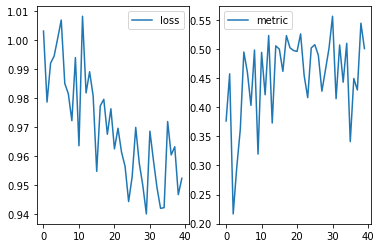

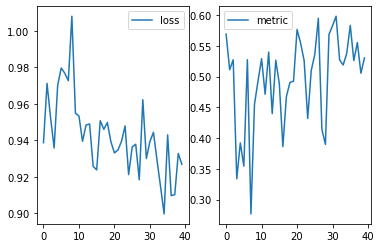

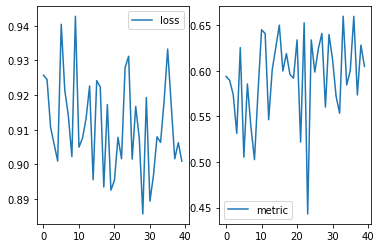

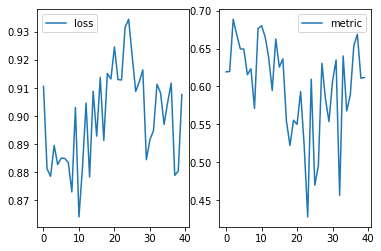

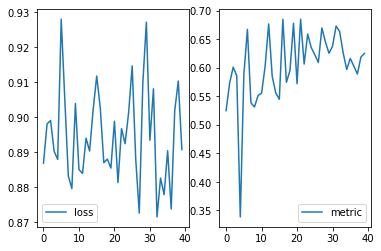

In [26]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()



    
model = UNet(
spatial_dims=3,
in_channels=1,
# With softmax 
out_channels=4,
channels=(16, 32, 64, 128,256),
strides=(2, 2, 2, 2),
dropout=0.2,
num_res_units=2,
norm="batch",


)
model.to(device)
if load_weights:
        model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))

optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
for fold in range(start_fold, start_fold + num_folds):    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    #lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    lr_scheduler = LR(optimizer, T_max=5, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Training Phase 5
Training the same model with all the folds to speed up training time
Apply softmax to labels before providing as input because they overlap in some cases

In [27]:
#Training settings  Note that this is meant to train the same model with each fold!


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 5
load_weights = True
fold = 4 # Provide fold to load initially

tr_transforms = train_transforms[0]
batch_size = 8

#tr_transforms = train_transforms[1]
#batch_size = 4

num_epochs = 40
num_folds = 5
start_fold = 0
val_interval = 1
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.CosineAnnealingLR
max_learning_rate = 0.001
min_learning_rate = 0.0005

----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/40  LR=0.001


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0676


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6459973454475403
saved new best metric model
current epoch: 1 current mean dice: 0.6460 best mean dice: 0.6460 at epoch 1
----------
epoch 2/40  LR=0.0008272542485937372


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0558


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.68114173412323
saved new best metric model
current epoch: 2 current mean dice: 0.6811 best mean dice: 0.6811 at epoch 2
----------
epoch 3/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0572


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6951518654823303
saved new best metric model
current epoch: 3 current mean dice: 0.6952 best mean dice: 0.6952 at epoch 3
----------
epoch 4/40  LR=0.0005477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0544


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5935001969337463
current epoch: 4 current mean dice: 0.5935 best mean dice: 0.6952 at epoch 3
----------
epoch 5/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0543


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.640620768070221
current epoch: 5 current mean dice: 0.6406 best mean dice: 0.6952 at epoch 3
----------
epoch 6/40  LR=0.001000000000000005


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0619


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49648764729499817
current epoch: 6 current mean dice: 0.4965 best mean dice: 0.6952 at epoch 3
----------
epoch 7/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0589


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6369720101356506
current epoch: 7 current mean dice: 0.6370 best mean dice: 0.6952 at epoch 3
----------
epoch 8/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0569


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6772046685218811
current epoch: 8 current mean dice: 0.6772 best mean dice: 0.6952 at epoch 3
----------
epoch 9/40  LR=0.0005477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0570


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6820725202560425
current epoch: 9 current mean dice: 0.6821 best mean dice: 0.6952 at epoch 3
----------
epoch 10/40  LR=0.0008272542485937482


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0562


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6821669936180115
current epoch: 10 current mean dice: 0.6822 best mean dice: 0.6952 at epoch 3
----------
epoch 11/40  LR=0.0009999999999999885


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0584


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.701324462890625
saved new best metric model
current epoch: 11 current mean dice: 0.7013 best mean dice: 0.7013 at epoch 11
----------
epoch 12/40  LR=0.0008272542485937388


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0559


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5267924666404724
current epoch: 12 current mean dice: 0.5268 best mean dice: 0.7013 at epoch 11
----------
epoch 13/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0593


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6657131314277649
current epoch: 13 current mean dice: 0.6657 best mean dice: 0.7013 at epoch 11
----------
epoch 14/40  LR=0.0005477457514062657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0597


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6341449022293091
current epoch: 14 current mean dice: 0.6341 best mean dice: 0.7013 at epoch 11
----------
epoch 15/40  LR=0.0008272542485937484


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0541


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6557433009147644
current epoch: 15 current mean dice: 0.6557 best mean dice: 0.7013 at epoch 11
----------
epoch 16/40  LR=0.0010000000000000156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0548


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6641108393669128
current epoch: 16 current mean dice: 0.6641 best mean dice: 0.7013 at epoch 11
----------
epoch 17/40  LR=0.0008272542485937524


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0540


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6639732122421265
current epoch: 17 current mean dice: 0.6640 best mean dice: 0.7013 at epoch 11
----------
epoch 18/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0588


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6039252877235413
current epoch: 18 current mean dice: 0.6039 best mean dice: 0.7013 at epoch 11
----------
epoch 19/40  LR=0.0005477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0535


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.606689453125
current epoch: 19 current mean dice: 0.6067 best mean dice: 0.7013 at epoch 11
----------
epoch 20/40  LR=0.0008272542485937568


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0552


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6991690397262573
current epoch: 20 current mean dice: 0.6992 best mean dice: 0.7013 at epoch 11
----------
epoch 21/40  LR=0.0010000000000000425


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0559


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6929724216461182
current epoch: 21 current mean dice: 0.6930 best mean dice: 0.7013 at epoch 11
----------
epoch 22/40  LR=0.0008272542485937796


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0553


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.668175995349884
current epoch: 22 current mean dice: 0.6682 best mean dice: 0.7013 at epoch 11
----------
epoch 23/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0585


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.640073299407959
current epoch: 23 current mean dice: 0.6401 best mean dice: 0.7013 at epoch 11
----------
epoch 24/40  LR=0.0005477457514062677


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0580


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5733718276023865
current epoch: 24 current mean dice: 0.5734 best mean dice: 0.7013 at epoch 11
----------
epoch 25/40  LR=0.0008272542485937785


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0739


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5807285308837891
current epoch: 25 current mean dice: 0.5807 best mean dice: 0.7013 at epoch 11
----------
epoch 26/40  LR=0.0010000000000000698


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0600


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6187548041343689
current epoch: 26 current mean dice: 0.6188 best mean dice: 0.7013 at epoch 11
----------
epoch 27/40  LR=0.0008272542485937224


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0599


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5616896748542786
current epoch: 27 current mean dice: 0.5617 best mean dice: 0.7013 at epoch 11
----------
epoch 28/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0616


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6034579873085022
current epoch: 28 current mean dice: 0.6035 best mean dice: 0.7013 at epoch 11
----------
epoch 29/40  LR=0.0005477457514062814


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0577


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.529267430305481
current epoch: 29 current mean dice: 0.5293 best mean dice: 0.7013 at epoch 11
----------
epoch 30/40  LR=0.0008272542485938004


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0619


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6801941394805908
current epoch: 30 current mean dice: 0.6802 best mean dice: 0.7013 at epoch 11
----------
epoch 31/40  LR=0.0010000000000000096


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0583


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6633073091506958
current epoch: 31 current mean dice: 0.6633 best mean dice: 0.7013 at epoch 11
----------
epoch 32/40  LR=0.000827254248593692


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0586


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.55743408203125
current epoch: 32 current mean dice: 0.5574 best mean dice: 0.7013 at epoch 11
----------
epoch 33/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0574


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6666625738143921
current epoch: 33 current mean dice: 0.6667 best mean dice: 0.7013 at epoch 11
----------
epoch 34/40  LR=0.0005477457514062781


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0604


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6475628018379211
current epoch: 34 current mean dice: 0.6476 best mean dice: 0.7013 at epoch 11
----------
epoch 35/40  LR=0.0008272542485937654


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0598


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5790584087371826
current epoch: 35 current mean dice: 0.5791 best mean dice: 0.7013 at epoch 11
----------
epoch 36/40  LR=0.0009999999999999493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0607


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6450434327125549
current epoch: 36 current mean dice: 0.6450 best mean dice: 0.7013 at epoch 11
----------
epoch 37/40  LR=0.0008272542485937766


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0558


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5777031779289246
current epoch: 37 current mean dice: 0.5777 best mean dice: 0.7013 at epoch 11
----------
epoch 38/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0576


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5715213418006897
current epoch: 38 current mean dice: 0.5715 best mean dice: 0.7013 at epoch 11
----------
epoch 39/40  LR=0.0005477457514062666


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0596


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.593278169631958
current epoch: 39 current mean dice: 0.5933 best mean dice: 0.7013 at epoch 11
----------
epoch 40/40  LR=0.0008272542485937167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0559


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5490843653678894
current epoch: 40 current mean dice: 0.5491 best mean dice: 0.7013 at epoch 11
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001000000000000064


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0585


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6208754181861877
saved new best metric model
current epoch: 1 current mean dice: 0.6209 best mean dice: 0.6209 at epoch 1
----------
epoch 2/40  LR=0.0008272542485937372


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0574


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6366822719573975
saved new best metric model
current epoch: 2 current mean dice: 0.6367 best mean dice: 0.6367 at epoch 2
----------
epoch 3/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0561


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6164506673812866
current epoch: 3 current mean dice: 0.6165 best mean dice: 0.6367 at epoch 2
----------
epoch 4/40  LR=0.0005477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0630


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.590907871723175
current epoch: 4 current mean dice: 0.5909 best mean dice: 0.6367 at epoch 2
----------
epoch 5/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0594


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6135215759277344
current epoch: 5 current mean dice: 0.6135 best mean dice: 0.6367 at epoch 2
----------
epoch 6/40  LR=0.001000000000000005


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0566


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6359387636184692
current epoch: 6 current mean dice: 0.6359 best mean dice: 0.6367 at epoch 2
----------
epoch 7/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0589


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4858390688896179
current epoch: 7 current mean dice: 0.4858 best mean dice: 0.6367 at epoch 2
----------
epoch 8/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0572


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6042900681495667
current epoch: 8 current mean dice: 0.6043 best mean dice: 0.6367 at epoch 2
----------
epoch 9/40  LR=0.0005477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0589


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4609825909137726
current epoch: 9 current mean dice: 0.4610 best mean dice: 0.6367 at epoch 2
----------
epoch 10/40  LR=0.0008272542485937482


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0642


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6600884199142456
saved new best metric model
current epoch: 10 current mean dice: 0.6601 best mean dice: 0.6601 at epoch 10
----------
epoch 11/40  LR=0.0009999999999999885


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0559


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.688454806804657
saved new best metric model
current epoch: 11 current mean dice: 0.6885 best mean dice: 0.6885 at epoch 11
----------
epoch 12/40  LR=0.0008272542485937388


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0562


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.628517210483551
current epoch: 12 current mean dice: 0.6285 best mean dice: 0.6885 at epoch 11
----------
epoch 13/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0612


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6558272838592529
current epoch: 13 current mean dice: 0.6558 best mean dice: 0.6885 at epoch 11
----------
epoch 14/40  LR=0.0005477457514062657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0552


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4252185523509979
current epoch: 14 current mean dice: 0.4252 best mean dice: 0.6885 at epoch 11
----------
epoch 15/40  LR=0.0008272542485937484


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0578


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5725764036178589
current epoch: 15 current mean dice: 0.5726 best mean dice: 0.6885 at epoch 11
----------
epoch 16/40  LR=0.0010000000000000156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0603


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.640194296836853
current epoch: 16 current mean dice: 0.6402 best mean dice: 0.6885 at epoch 11
----------
epoch 17/40  LR=0.0008272542485937524


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0599


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6270568370819092
current epoch: 17 current mean dice: 0.6271 best mean dice: 0.6885 at epoch 11
----------
epoch 18/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0623


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6846340298652649
current epoch: 18 current mean dice: 0.6846 best mean dice: 0.6885 at epoch 11
----------
epoch 19/40  LR=0.0005477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0635


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6333931088447571
current epoch: 19 current mean dice: 0.6334 best mean dice: 0.6885 at epoch 11
----------
epoch 20/40  LR=0.0008272542485937568


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0626


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5013004541397095
current epoch: 20 current mean dice: 0.5013 best mean dice: 0.6885 at epoch 11
----------
epoch 21/40  LR=0.0010000000000000425


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0592


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6449534893035889
current epoch: 21 current mean dice: 0.6450 best mean dice: 0.6885 at epoch 11
----------
epoch 22/40  LR=0.0008272542485937796


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0555


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6322835683822632
current epoch: 22 current mean dice: 0.6323 best mean dice: 0.6885 at epoch 11
----------
epoch 23/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0561


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6538071632385254
current epoch: 23 current mean dice: 0.6538 best mean dice: 0.6885 at epoch 11
----------
epoch 24/40  LR=0.0005477457514062677


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0626


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.32618603110313416
current epoch: 24 current mean dice: 0.3262 best mean dice: 0.6885 at epoch 11
----------
epoch 25/40  LR=0.0008272542485937785


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0597


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6644037365913391
current epoch: 25 current mean dice: 0.6644 best mean dice: 0.6885 at epoch 11
----------
epoch 26/40  LR=0.0010000000000000698


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0573


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6906018257141113
saved new best metric model
current epoch: 26 current mean dice: 0.6906 best mean dice: 0.6906 at epoch 26
----------
epoch 27/40  LR=0.0008272542485937224


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0566


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5962620973587036
current epoch: 27 current mean dice: 0.5963 best mean dice: 0.6906 at epoch 26
----------
epoch 28/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0576


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6116901636123657
current epoch: 28 current mean dice: 0.6117 best mean dice: 0.6906 at epoch 26
----------
epoch 29/40  LR=0.0005477457514062814


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0590


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6011446118354797
current epoch: 29 current mean dice: 0.6011 best mean dice: 0.6906 at epoch 26
----------
epoch 30/40  LR=0.0008272542485938004


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0569


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5917977094650269
current epoch: 30 current mean dice: 0.5918 best mean dice: 0.6906 at epoch 26
----------
epoch 31/40  LR=0.0010000000000000096


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0615


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.39983609318733215
current epoch: 31 current mean dice: 0.3998 best mean dice: 0.6906 at epoch 26
----------
epoch 32/40  LR=0.000827254248593692


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0695


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6841320395469666
current epoch: 32 current mean dice: 0.6841 best mean dice: 0.6906 at epoch 26
----------
epoch 33/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0599


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5199532508850098
current epoch: 33 current mean dice: 0.5200 best mean dice: 0.6906 at epoch 26
----------
epoch 34/40  LR=0.0005477457514062781


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0591


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6965163946151733
saved new best metric model
current epoch: 34 current mean dice: 0.6965 best mean dice: 0.6965 at epoch 34
----------
epoch 35/40  LR=0.0008272542485937654


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0583


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6427017450332642
current epoch: 35 current mean dice: 0.6427 best mean dice: 0.6965 at epoch 34
----------
epoch 36/40  LR=0.0009999999999999493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0548


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7281515598297119
saved new best metric model
current epoch: 36 current mean dice: 0.7282 best mean dice: 0.7282 at epoch 36
----------
epoch 37/40  LR=0.0008272542485937766


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0537


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7031886577606201
current epoch: 37 current mean dice: 0.7032 best mean dice: 0.7282 at epoch 36
----------
epoch 38/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0528


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6850084662437439
current epoch: 38 current mean dice: 0.6850 best mean dice: 0.7282 at epoch 36
----------
epoch 39/40  LR=0.0005477457514062666


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0562


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4271450638771057
current epoch: 39 current mean dice: 0.4271 best mean dice: 0.7282 at epoch 36
----------
epoch 40/40  LR=0.0008272542485937167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0586


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6225820779800415
current epoch: 40 current mean dice: 0.6226 best mean dice: 0.7282 at epoch 36
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001000000000000064


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0589


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5033857226371765
saved new best metric model
current epoch: 1 current mean dice: 0.5034 best mean dice: 0.5034 at epoch 1
----------
epoch 2/40  LR=0.0008272542485937372


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0586


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6732212901115417
saved new best metric model
current epoch: 2 current mean dice: 0.6732 best mean dice: 0.6732 at epoch 2
----------
epoch 3/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0583


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5188508033752441
current epoch: 3 current mean dice: 0.5189 best mean dice: 0.6732 at epoch 2
----------
epoch 4/40  LR=0.0005477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0593


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6061932444572449
current epoch: 4 current mean dice: 0.6062 best mean dice: 0.6732 at epoch 2
----------
epoch 5/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0591


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6906251907348633
saved new best metric model
current epoch: 5 current mean dice: 0.6906 best mean dice: 0.6906 at epoch 5
----------
epoch 6/40  LR=0.001000000000000005


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0600


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5899761319160461
current epoch: 6 current mean dice: 0.5900 best mean dice: 0.6906 at epoch 5
----------
epoch 7/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0567


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6835745573043823
current epoch: 7 current mean dice: 0.6836 best mean dice: 0.6906 at epoch 5
----------
epoch 8/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0606


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.633019208908081
current epoch: 8 current mean dice: 0.6330 best mean dice: 0.6906 at epoch 5
----------
epoch 9/40  LR=0.0005477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0572


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4266173243522644
current epoch: 9 current mean dice: 0.4266 best mean dice: 0.6906 at epoch 5
----------
epoch 10/40  LR=0.0008272542485937482


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0581


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.725389301776886
saved new best metric model
current epoch: 10 current mean dice: 0.7254 best mean dice: 0.7254 at epoch 10
----------
epoch 11/40  LR=0.0009999999999999885


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0573


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6574002504348755
current epoch: 11 current mean dice: 0.6574 best mean dice: 0.7254 at epoch 10
----------
epoch 12/40  LR=0.0008272542485937388


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0562


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6948693990707397
current epoch: 12 current mean dice: 0.6949 best mean dice: 0.7254 at epoch 10
----------
epoch 13/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0574


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5795902013778687
current epoch: 13 current mean dice: 0.5796 best mean dice: 0.7254 at epoch 10
----------
epoch 14/40  LR=0.0005477457514062657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0625


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6856905817985535
current epoch: 14 current mean dice: 0.6857 best mean dice: 0.7254 at epoch 10
----------
epoch 15/40  LR=0.0008272542485937484


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0592


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5032915472984314
current epoch: 15 current mean dice: 0.5033 best mean dice: 0.7254 at epoch 10
----------
epoch 16/40  LR=0.0010000000000000156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0568


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.657514214515686
current epoch: 16 current mean dice: 0.6575 best mean dice: 0.7254 at epoch 10
----------
epoch 17/40  LR=0.0008272542485937524


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0619


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5071415901184082
current epoch: 17 current mean dice: 0.5071 best mean dice: 0.7254 at epoch 10
----------
epoch 18/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0681


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4571124017238617
current epoch: 18 current mean dice: 0.4571 best mean dice: 0.7254 at epoch 10
----------
epoch 19/40  LR=0.0005477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0696


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6294355988502502
current epoch: 19 current mean dice: 0.6294 best mean dice: 0.7254 at epoch 10
----------
epoch 20/40  LR=0.0008272542485937568


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0710


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4911477565765381
current epoch: 20 current mean dice: 0.4911 best mean dice: 0.7254 at epoch 10
----------
epoch 21/40  LR=0.0010000000000000425


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0666


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5649632811546326
current epoch: 21 current mean dice: 0.5650 best mean dice: 0.7254 at epoch 10
----------
epoch 22/40  LR=0.0008272542485937796


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0649


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6180440783500671
current epoch: 22 current mean dice: 0.6180 best mean dice: 0.7254 at epoch 10
----------
epoch 23/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0681


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4590115249156952
current epoch: 23 current mean dice: 0.4590 best mean dice: 0.7254 at epoch 10
----------
epoch 24/40  LR=0.0005477457514062677


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0673


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.48272979259490967
current epoch: 24 current mean dice: 0.4827 best mean dice: 0.7254 at epoch 10
----------
epoch 25/40  LR=0.0008272542485937785


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0668


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.26955652236938477
current epoch: 25 current mean dice: 0.2696 best mean dice: 0.7254 at epoch 10
----------
epoch 26/40  LR=0.0010000000000000698


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0652


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5829867720603943
current epoch: 26 current mean dice: 0.5830 best mean dice: 0.7254 at epoch 10
----------
epoch 27/40  LR=0.0008272542485937224


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0669


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.557835042476654
current epoch: 27 current mean dice: 0.5578 best mean dice: 0.7254 at epoch 10
----------
epoch 28/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0643


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3974047899246216
current epoch: 28 current mean dice: 0.3974 best mean dice: 0.7254 at epoch 10
----------
epoch 29/40  LR=0.0005477457514062814


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0605


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.40966230630874634
current epoch: 29 current mean dice: 0.4097 best mean dice: 0.7254 at epoch 10
----------
epoch 30/40  LR=0.0008272542485938004


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0624


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6448652744293213
current epoch: 30 current mean dice: 0.6449 best mean dice: 0.7254 at epoch 10
----------
epoch 31/40  LR=0.0010000000000000096


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0687


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6437552571296692
current epoch: 31 current mean dice: 0.6438 best mean dice: 0.7254 at epoch 10
----------
epoch 32/40  LR=0.000827254248593692


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0646


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5695947408676147
current epoch: 32 current mean dice: 0.5696 best mean dice: 0.7254 at epoch 10
----------
epoch 33/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0669


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5932556986808777
current epoch: 33 current mean dice: 0.5933 best mean dice: 0.7254 at epoch 10
----------
epoch 34/40  LR=0.0005477457514062781


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0593


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.28790467977523804
current epoch: 34 current mean dice: 0.2879 best mean dice: 0.7254 at epoch 10
----------
epoch 35/40  LR=0.0008272542485937654


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0676


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5958846807479858
current epoch: 35 current mean dice: 0.5959 best mean dice: 0.7254 at epoch 10
----------
epoch 36/40  LR=0.0009999999999999493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0643


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6135262846946716
current epoch: 36 current mean dice: 0.6135 best mean dice: 0.7254 at epoch 10
----------
epoch 37/40  LR=0.0008272542485937766


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0596


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5608209371566772
current epoch: 37 current mean dice: 0.5608 best mean dice: 0.7254 at epoch 10
----------
epoch 38/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0647


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.510234534740448
current epoch: 38 current mean dice: 0.5102 best mean dice: 0.7254 at epoch 10
----------
epoch 39/40  LR=0.0005477457514062666


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0626


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6814884543418884
current epoch: 39 current mean dice: 0.6815 best mean dice: 0.7254 at epoch 10
----------
epoch 40/40  LR=0.0008272542485937167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0622


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5401276350021362
current epoch: 40 current mean dice: 0.5401 best mean dice: 0.7254 at epoch 10
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001000000000000064


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0591


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5389191508293152
saved new best metric model
current epoch: 1 current mean dice: 0.5389 best mean dice: 0.5389 at epoch 1
----------
epoch 2/40  LR=0.0008272542485937372


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0617


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5643115639686584
saved new best metric model
current epoch: 2 current mean dice: 0.5643 best mean dice: 0.5643 at epoch 2
----------
epoch 3/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0580


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6527417302131653
saved new best metric model
current epoch: 3 current mean dice: 0.6527 best mean dice: 0.6527 at epoch 3
----------
epoch 4/40  LR=0.0005477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0586


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6164430975914001
current epoch: 4 current mean dice: 0.6164 best mean dice: 0.6527 at epoch 3
----------
epoch 5/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0587


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6747660040855408
saved new best metric model
current epoch: 5 current mean dice: 0.6748 best mean dice: 0.6748 at epoch 5
----------
epoch 6/40  LR=0.001000000000000005


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0594


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5895148515701294
current epoch: 6 current mean dice: 0.5895 best mean dice: 0.6748 at epoch 5
----------
epoch 7/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0562


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6737121343612671
current epoch: 7 current mean dice: 0.6737 best mean dice: 0.6748 at epoch 5
----------
epoch 8/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0620


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5224559903144836
current epoch: 8 current mean dice: 0.5225 best mean dice: 0.6748 at epoch 5
----------
epoch 9/40  LR=0.0005477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0617


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6518512964248657
current epoch: 9 current mean dice: 0.6519 best mean dice: 0.6748 at epoch 5
----------
epoch 10/40  LR=0.0008272542485937482


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0634


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5574434399604797
current epoch: 10 current mean dice: 0.5574 best mean dice: 0.6748 at epoch 5
----------
epoch 11/40  LR=0.0009999999999999885


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0637


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5565473437309265
current epoch: 11 current mean dice: 0.5565 best mean dice: 0.6748 at epoch 5
----------
epoch 12/40  LR=0.0008272542485937388


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0615


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.676774263381958
saved new best metric model
current epoch: 12 current mean dice: 0.6768 best mean dice: 0.6768 at epoch 12
----------
epoch 13/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0636


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4002910256385803
current epoch: 13 current mean dice: 0.4003 best mean dice: 0.6768 at epoch 12
----------
epoch 14/40  LR=0.0005477457514062657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0684


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.31790611147880554
current epoch: 14 current mean dice: 0.3179 best mean dice: 0.6768 at epoch 12
----------
epoch 15/40  LR=0.0008272542485937484


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0618


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5079656839370728
current epoch: 15 current mean dice: 0.5080 best mean dice: 0.6768 at epoch 12
----------
epoch 16/40  LR=0.0010000000000000156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0635


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6382245421409607
current epoch: 16 current mean dice: 0.6382 best mean dice: 0.6768 at epoch 12
----------
epoch 17/40  LR=0.0008272542485937524


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0604


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5740805864334106
current epoch: 17 current mean dice: 0.5741 best mean dice: 0.6768 at epoch 12
----------
epoch 18/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0614


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4553949534893036
current epoch: 18 current mean dice: 0.4554 best mean dice: 0.6768 at epoch 12
----------
epoch 19/40  LR=0.0005477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0625


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4184771776199341
current epoch: 19 current mean dice: 0.4185 best mean dice: 0.6768 at epoch 12
----------
epoch 20/40  LR=0.0008272542485937568


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0624


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5703103542327881
current epoch: 20 current mean dice: 0.5703 best mean dice: 0.6768 at epoch 12
----------
epoch 21/40  LR=0.0010000000000000425


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0599


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5944129824638367
current epoch: 21 current mean dice: 0.5944 best mean dice: 0.6768 at epoch 12
----------
epoch 22/40  LR=0.0008272542485937796


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0632


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6321467161178589
current epoch: 22 current mean dice: 0.6321 best mean dice: 0.6768 at epoch 12
----------
epoch 23/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0604


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5587327480316162
current epoch: 23 current mean dice: 0.5587 best mean dice: 0.6768 at epoch 12
----------
epoch 24/40  LR=0.0005477457514062677


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0616


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6864716410636902
saved new best metric model
current epoch: 24 current mean dice: 0.6865 best mean dice: 0.6865 at epoch 24
----------
epoch 25/40  LR=0.0008272542485937785


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0570


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6021487712860107
current epoch: 25 current mean dice: 0.6021 best mean dice: 0.6865 at epoch 24
----------
epoch 26/40  LR=0.0010000000000000698


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0634


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.60423743724823
current epoch: 26 current mean dice: 0.6042 best mean dice: 0.6865 at epoch 24
----------
epoch 27/40  LR=0.0008272542485937224


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0600


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6074082851409912
current epoch: 27 current mean dice: 0.6074 best mean dice: 0.6865 at epoch 24
----------
epoch 28/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0624


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.647101104259491
current epoch: 28 current mean dice: 0.6471 best mean dice: 0.6865 at epoch 24
----------
epoch 29/40  LR=0.0005477457514062814


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0606


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5469893217086792
current epoch: 29 current mean dice: 0.5470 best mean dice: 0.6865 at epoch 24
----------
epoch 30/40  LR=0.0008272542485938004


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0615


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5353331565856934
current epoch: 30 current mean dice: 0.5353 best mean dice: 0.6865 at epoch 24
----------
epoch 31/40  LR=0.0010000000000000096


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0631


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6226057410240173
current epoch: 31 current mean dice: 0.6226 best mean dice: 0.6865 at epoch 24
----------
epoch 32/40  LR=0.000827254248593692


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0658


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6290240287780762
current epoch: 32 current mean dice: 0.6290 best mean dice: 0.6865 at epoch 24
----------
epoch 33/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0625


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6455468535423279
current epoch: 33 current mean dice: 0.6455 best mean dice: 0.6865 at epoch 24
----------
epoch 34/40  LR=0.0005477457514062781


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0640


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5496965050697327
current epoch: 34 current mean dice: 0.5497 best mean dice: 0.6865 at epoch 24
----------
epoch 35/40  LR=0.0008272542485937654


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0612


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5125929713249207
current epoch: 35 current mean dice: 0.5126 best mean dice: 0.6865 at epoch 24
----------
epoch 36/40  LR=0.0009999999999999493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0630


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6765002012252808
current epoch: 36 current mean dice: 0.6765 best mean dice: 0.6865 at epoch 24
----------
epoch 37/40  LR=0.0008272542485937766


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0580


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6610788106918335
current epoch: 37 current mean dice: 0.6611 best mean dice: 0.6865 at epoch 24
----------
epoch 38/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0563


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5993865728378296
current epoch: 38 current mean dice: 0.5994 best mean dice: 0.6865 at epoch 24
----------
epoch 39/40  LR=0.0005477457514062666


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0628


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6383455991744995
current epoch: 39 current mean dice: 0.6383 best mean dice: 0.6865 at epoch 24
----------
epoch 40/40  LR=0.0008272542485937167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0590


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.598535418510437
current epoch: 40 current mean dice: 0.5985 best mean dice: 0.6865 at epoch 24
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=0.001000000000000064


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0595


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5955893993377686
saved new best metric model
current epoch: 1 current mean dice: 0.5956 best mean dice: 0.5956 at epoch 1
----------
epoch 2/40  LR=0.0008272542485937372


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0617


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5954824090003967
current epoch: 2 current mean dice: 0.5955 best mean dice: 0.5956 at epoch 1
----------
epoch 3/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0571


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6498958468437195
saved new best metric model
current epoch: 3 current mean dice: 0.6499 best mean dice: 0.6499 at epoch 3
----------
epoch 4/40  LR=0.0005477457514062637


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0613


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6272879838943481
current epoch: 4 current mean dice: 0.6273 best mean dice: 0.6499 at epoch 3
----------
epoch 5/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0565


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5946714878082275
current epoch: 5 current mean dice: 0.5947 best mean dice: 0.6499 at epoch 3
----------
epoch 6/40  LR=0.001000000000000005


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0615


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4542301595211029
current epoch: 6 current mean dice: 0.4542 best mean dice: 0.6499 at epoch 3
----------
epoch 7/40  LR=0.000827254248593733


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0658


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6359381675720215
current epoch: 7 current mean dice: 0.6359 best mean dice: 0.6499 at epoch 3
----------
epoch 8/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0643


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.668799638748169
saved new best metric model
current epoch: 8 current mean dice: 0.6688 best mean dice: 0.6688 at epoch 8
----------
epoch 9/40  LR=0.0005477457514062648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0626


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5840610861778259
current epoch: 9 current mean dice: 0.5841 best mean dice: 0.6688 at epoch 8
----------
epoch 10/40  LR=0.0008272542485937482


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0600


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5290710926055908
current epoch: 10 current mean dice: 0.5291 best mean dice: 0.6688 at epoch 8
----------
epoch 11/40  LR=0.0009999999999999885


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0555


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6961246728897095
saved new best metric model
current epoch: 11 current mean dice: 0.6961 best mean dice: 0.6961 at epoch 11
----------
epoch 12/40  LR=0.0008272542485937388


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0518


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6768920421600342
current epoch: 12 current mean dice: 0.6769 best mean dice: 0.6961 at epoch 11
----------
epoch 13/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0566


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6048660278320312
current epoch: 13 current mean dice: 0.6049 best mean dice: 0.6961 at epoch 11
----------
epoch 14/40  LR=0.0005477457514062657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0582


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.645460307598114
current epoch: 14 current mean dice: 0.6455 best mean dice: 0.6961 at epoch 11
----------
epoch 15/40  LR=0.0008272542485937484


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0578


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7095203995704651
saved new best metric model
current epoch: 15 current mean dice: 0.7095 best mean dice: 0.7095 at epoch 15
----------
epoch 16/40  LR=0.0010000000000000156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0574


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5685466527938843
current epoch: 16 current mean dice: 0.5685 best mean dice: 0.7095 at epoch 15
----------
epoch 17/40  LR=0.0008272542485937524


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0585


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6501478552818298
current epoch: 17 current mean dice: 0.6501 best mean dice: 0.7095 at epoch 15
----------
epoch 18/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0626


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5449594855308533
current epoch: 18 current mean dice: 0.5450 best mean dice: 0.7095 at epoch 15
----------
epoch 19/40  LR=0.0005477457514062626


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0609


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5692573189735413
current epoch: 19 current mean dice: 0.5693 best mean dice: 0.7095 at epoch 15
----------
epoch 20/40  LR=0.0008272542485937568


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0614


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5899381041526794
current epoch: 20 current mean dice: 0.5899 best mean dice: 0.7095 at epoch 15
----------
epoch 21/40  LR=0.0010000000000000425


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0648


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6699809432029724
current epoch: 21 current mean dice: 0.6700 best mean dice: 0.7095 at epoch 15
----------
epoch 22/40  LR=0.0008272542485937796


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0554


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6810594201087952
current epoch: 22 current mean dice: 0.6811 best mean dice: 0.7095 at epoch 15
----------
epoch 23/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0587


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6970693469047546
current epoch: 23 current mean dice: 0.6971 best mean dice: 0.7095 at epoch 15
----------
epoch 24/40  LR=0.0005477457514062677


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0570


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.583705723285675
current epoch: 24 current mean dice: 0.5837 best mean dice: 0.7095 at epoch 15
----------
epoch 25/40  LR=0.0008272542485937785


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0598


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6762380003929138
current epoch: 25 current mean dice: 0.6762 best mean dice: 0.7095 at epoch 15
----------
epoch 26/40  LR=0.0010000000000000698


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0591


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6223839521408081
current epoch: 26 current mean dice: 0.6224 best mean dice: 0.7095 at epoch 15
----------
epoch 27/40  LR=0.0008272542485937224


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0608


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6907563805580139
current epoch: 27 current mean dice: 0.6908 best mean dice: 0.7095 at epoch 15
----------
epoch 28/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0611


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5011043548583984
current epoch: 28 current mean dice: 0.5011 best mean dice: 0.7095 at epoch 15
----------
epoch 29/40  LR=0.0005477457514062814


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0615


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6074269413948059
current epoch: 29 current mean dice: 0.6074 best mean dice: 0.7095 at epoch 15
----------
epoch 30/40  LR=0.0008272542485938004


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0626


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5840867757797241
current epoch: 30 current mean dice: 0.5841 best mean dice: 0.7095 at epoch 15
----------
epoch 31/40  LR=0.0010000000000000096


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0590


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6035121083259583
current epoch: 31 current mean dice: 0.6035 best mean dice: 0.7095 at epoch 15
----------
epoch 32/40  LR=0.000827254248593692


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0571


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6230931878089905
current epoch: 32 current mean dice: 0.6231 best mean dice: 0.7095 at epoch 15
----------
epoch 33/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0654


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6436945199966431
current epoch: 33 current mean dice: 0.6437 best mean dice: 0.7095 at epoch 15
----------
epoch 34/40  LR=0.0005477457514062781


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0671


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49730661511421204
current epoch: 34 current mean dice: 0.4973 best mean dice: 0.7095 at epoch 15
----------
epoch 35/40  LR=0.0008272542485937654


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0742


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5586166381835938
current epoch: 35 current mean dice: 0.5586 best mean dice: 0.7095 at epoch 15
----------
epoch 36/40  LR=0.0009999999999999493


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0686


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5580563545227051
current epoch: 36 current mean dice: 0.5581 best mean dice: 0.7095 at epoch 15
----------
epoch 37/40  LR=0.0008272542485937766


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0702


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.43723198771476746
current epoch: 37 current mean dice: 0.4372 best mean dice: 0.7095 at epoch 15
----------
epoch 38/40  LR=0.0005477457514062631


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0704


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5662248730659485
current epoch: 38 current mean dice: 0.5662 best mean dice: 0.7095 at epoch 15
----------
epoch 39/40  LR=0.0005477457514062666


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0671


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5074257850646973
current epoch: 39 current mean dice: 0.5074 best mean dice: 0.7095 at epoch 15
----------
epoch 40/40  LR=0.0008272542485937167


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0629


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6072121262550354
current epoch: 40 current mean dice: 0.6072 best mean dice: 0.7095 at epoch 15


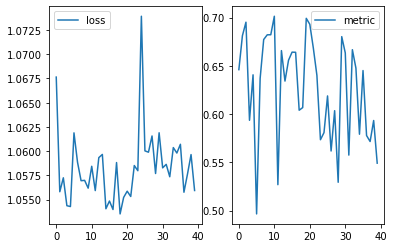

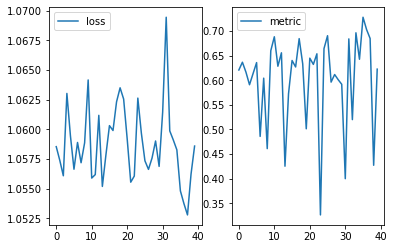

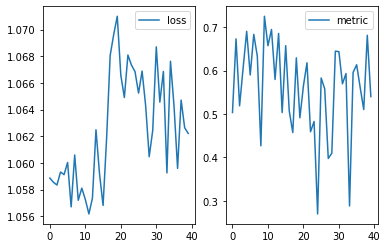

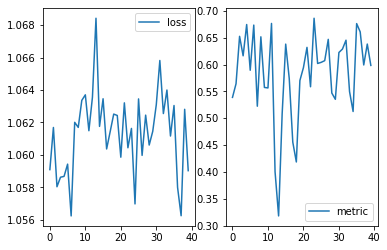

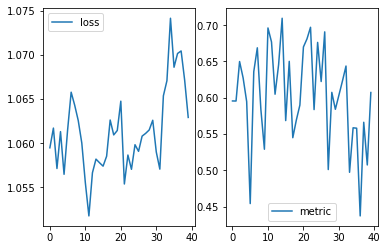

In [28]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()



    
model = UNet(
spatial_dims=3,
in_channels=1,
# With softmax 
out_channels=4,
channels=(16, 32, 64, 128,256),
strides=(2, 2, 2, 2),
dropout=0.2,
num_res_units=2,
norm="batch",


)
model.to(device)
if load_weights:
        model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))

optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
for fold in range(start_fold, start_fold + num_folds):    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    #lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    lr_scheduler = LR(optimizer, T_max=5, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            #Apply softmax to labels because they overlap in some cases
            labels = torch.nn.Softmax(dim=1)(labels)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Training Phase 6
Training the same model with all the folds to speed up training time
Make it a multi-class problem again and see if loss goes down more quickly


In [36]:
#Training settings  Note that this is meant to train the same model with each fold!


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 6
load_weights = True
weights_file ='4_best_dict_5.pth'
fold = 4 # Provide fold to load initially

tr_transforms = train_transforms[0]
batch_size = 8

#tr_transforms = train_transforms[1]
#batch_size = 4

num_epochs = 40
num_folds = 5
start_fold = 0
val_interval = 5
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True,sigmoid = False)  # make multi-class

#LR = torch.optim.lr_scheduler.CosineAnnealingLR
LR = torch.optim.lr_scheduler.OneCycleLR
max_learning_rate = 0.001
#min_learning_rate = 0.0002

----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0527
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0528
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0520
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0540
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0535


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7053641676902771
saved new best metric model
current epoch: 5 current mean dice: 0.7054 best mean dice: 0.7054 at epoch 5
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0547
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0551
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0579
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0613
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0648


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5963180661201477
current epoch: 10 current mean dice: 0.5963 best mean dice: 0.7054 at epoch 5
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0633
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0628
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0657
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0610
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0609


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5772990584373474
current epoch: 15 current mean dice: 0.5773 best mean dice: 0.7054 at epoch 5
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0647
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0644
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0628
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0595
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0630


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5918111205101013
current epoch: 20 current mean dice: 0.5918 best mean dice: 0.7054 at epoch 5
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0603
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0580
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0558
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0602
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0590


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5645521879196167
current epoch: 25 current mean dice: 0.5646 best mean dice: 0.7054 at epoch 5
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0574
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0599
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0559
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0544
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0533


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6935280561447144
current epoch: 30 current mean dice: 0.6935 best mean dice: 0.7054 at epoch 5
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0520
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0519
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0515
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0511
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0506


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.735593318939209
saved new best metric model
current epoch: 35 current mean dice: 0.7356 best mean dice: 0.7356 at epoch 35
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0514
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0481
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0484
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0469
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0493


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7479491233825684
saved new best metric model
current epoch: 40 current mean dice: 0.7479 best mean dice: 0.7479 at epoch 40
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0472
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0480
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0480
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0494
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0511


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7407552599906921
saved new best metric model
current epoch: 5 current mean dice: 0.7408 best mean dice: 0.7408 at epoch 5
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0512
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0540
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0561
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0616
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0613


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6372756958007812
current epoch: 10 current mean dice: 0.6373 best mean dice: 0.7408 at epoch 5
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0619
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0681
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0671
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0650
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0640


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5665159821510315
current epoch: 15 current mean dice: 0.5665 best mean dice: 0.7408 at epoch 5
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0694
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0611
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0588
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0593
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0617


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.45676785707473755
current epoch: 20 current mean dice: 0.4568 best mean dice: 0.7408 at epoch 5
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0605
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0615
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0614
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0593
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0581


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6632871031761169
current epoch: 25 current mean dice: 0.6633 best mean dice: 0.7408 at epoch 5
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0573
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0549
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0547
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0548
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0499


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7163659930229187
current epoch: 30 current mean dice: 0.7164 best mean dice: 0.7408 at epoch 5
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0496
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0509
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0488
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0515
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0485


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7481932044029236
saved new best metric model
current epoch: 35 current mean dice: 0.7482 best mean dice: 0.7482 at epoch 35
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0492
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0488
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0484
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0485
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0499


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7544288039207458
saved new best metric model
current epoch: 40 current mean dice: 0.7544 best mean dice: 0.7544 at epoch 40
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0497
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0464
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0492
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0509
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0528


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7051281332969666
saved new best metric model
current epoch: 5 current mean dice: 0.7051 best mean dice: 0.7051 at epoch 5
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0543
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0555
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0621
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0627
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0709


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.39436107873916626
current epoch: 10 current mean dice: 0.3944 best mean dice: 0.7051 at epoch 5
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0785
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0714
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0702
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0682
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0664


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6002650856971741
current epoch: 15 current mean dice: 0.6003 best mean dice: 0.7051 at epoch 5
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0617
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0631
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0628
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0620
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0618


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5913128852844238
current epoch: 20 current mean dice: 0.5913 best mean dice: 0.7051 at epoch 5
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0637
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0574
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0636
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0597
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0580


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6838762164115906
current epoch: 25 current mean dice: 0.6839 best mean dice: 0.7051 at epoch 5
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0567
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0604
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0543
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0525
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0524


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6485416293144226
current epoch: 30 current mean dice: 0.6485 best mean dice: 0.7051 at epoch 5
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0500
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0528
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0567
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0479
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0490


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7550954222679138
saved new best metric model
current epoch: 35 current mean dice: 0.7551 best mean dice: 0.7551 at epoch 35
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0478
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0487
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0478
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0492
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0475


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7649344801902771
saved new best metric model
current epoch: 40 current mean dice: 0.7649 best mean dice: 0.7649 at epoch 40
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0529
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0472
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0494
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0490
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0547


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6757440567016602
saved new best metric model
current epoch: 5 current mean dice: 0.6757 best mean dice: 0.6757 at epoch 5
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0518
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0571
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0667
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0575
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0629


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.503135085105896
current epoch: 10 current mean dice: 0.5031 best mean dice: 0.6757 at epoch 5
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0651
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0690
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0703
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0703
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0632


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5682688355445862
current epoch: 15 current mean dice: 0.5683 best mean dice: 0.6757 at epoch 5
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0617
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0620
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0684
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0679
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0587


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5721502304077148
current epoch: 20 current mean dice: 0.5722 best mean dice: 0.6757 at epoch 5
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0572
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0593
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0639
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0578
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0588


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.633029043674469
current epoch: 25 current mean dice: 0.6330 best mean dice: 0.6757 at epoch 5
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0568
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0600
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0555
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0547
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0539


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6994293332099915
saved new best metric model
current epoch: 30 current mean dice: 0.6994 best mean dice: 0.6994 at epoch 30
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0524
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0523
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0507
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0487
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0484


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.753201961517334
saved new best metric model
current epoch: 35 current mean dice: 0.7532 best mean dice: 0.7532 at epoch 35
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0478
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0464
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0452
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0512
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0462


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7562651634216309
saved new best metric model
current epoch: 40 current mean dice: 0.7563 best mean dice: 0.7563 at epoch 40
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0485
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0474
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0464
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0491
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0474


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7498108148574829
saved new best metric model
current epoch: 5 current mean dice: 0.7498 best mean dice: 0.7498 at epoch 5
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0511
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0534
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0509
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0568
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0537


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5769169330596924
current epoch: 10 current mean dice: 0.5769 best mean dice: 0.7498 at epoch 5
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0600
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0603
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0629
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0729
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0735


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3155285716056824
current epoch: 15 current mean dice: 0.3155 best mean dice: 0.7498 at epoch 5
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0786
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0720
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0668
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0667
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0643


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4659780263900757
current epoch: 20 current mean dice: 0.4660 best mean dice: 0.7498 at epoch 5
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0639
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0649
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0640
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0591
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0587


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6642966270446777
current epoch: 25 current mean dice: 0.6643 best mean dice: 0.7498 at epoch 5
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0604
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0557
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0515
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0493
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0536


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6947541832923889
current epoch: 30 current mean dice: 0.6948 best mean dice: 0.7498 at epoch 5
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0524
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0550
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0502
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0494
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0502


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7534400224685669
saved new best metric model
current epoch: 35 current mean dice: 0.7534 best mean dice: 0.7534 at epoch 35
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0505
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0464
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0471
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0469
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0465


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7456623911857605
current epoch: 40 current mean dice: 0.7457 best mean dice: 0.7534 at epoch 35


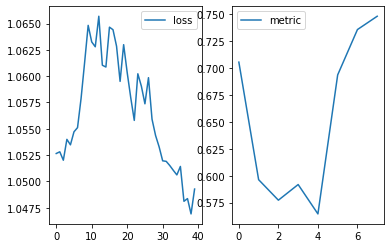

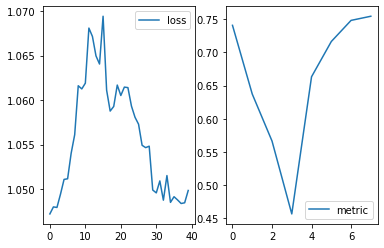

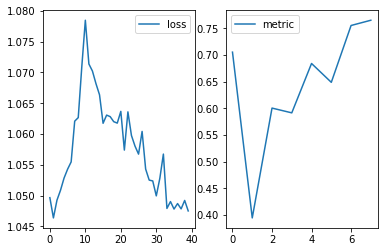

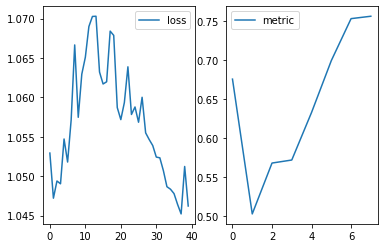

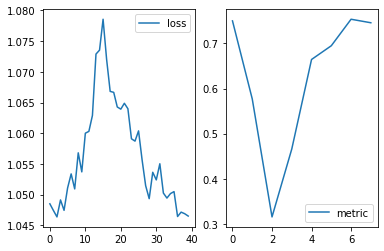

In [37]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])
#post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()



    
model = UNet(
spatial_dims=3,
in_channels=1,
# With softmax 
out_channels=4,
channels=(16, 32, 64, 128,256),
strides=(2, 2, 2, 2),
dropout=0.2,
num_res_units=2,
norm="batch",


)
model.to(device)
if load_weights:
        model.load_state_dict(torch.load(MODEL_FOLDER / weights_file))

optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
for fold in range(start_fold, start_fold + num_folds):    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    #lr_scheduler = LR(optimizer, T_max=10, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            #Apply softmax to labels because they overlap in some cases
            labels = torch.nn.Softmax(dim=1)(labels)
            
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Training Phase 7
Training the same model with all the folds to speed up training time
Make it a multi-class problem again and see if loss goes down more quickly


In [38]:
#Training settings  Note that this is meant to train the same model with each fold!


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 7
load_weights = True
weights_file ='4_dict_6.pth'
fold = 4 # Provide fold to load initially

tr_transforms = train_transforms[0]
batch_size = 8

#tr_transforms = train_transforms[1]
#batch_size = 4

num_epochs = 40
num_folds = 5
start_fold = 0
val_interval = 10
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True,sigmoid = False)  # make multi-class

#LR = torch.optim.lr_scheduler.CosineAnnealingLR
LR = torch.optim.lr_scheduler.OneCycleLR
max_learning_rate = 0.001
#min_learning_rate = 0.0002

----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0492
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0470
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0471
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0520
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0487
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0551
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0579
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0580
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0636
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0611


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6177354454994202
saved new best metric model
current epoch: 10 current mean dice: 0.6177 best mean dice: 0.6177 at epoch 10
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0629
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0665
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0701
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0628
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0616
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0632
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0609
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0627
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0626
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0611


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5866959691047668
current epoch: 20 current mean dice: 0.5867 best mean dice: 0.6177 at epoch 10
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0604
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0632
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0592
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0607
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0561
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0544
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0544
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0551
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0552
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0532


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6997559070587158
saved new best metric model
current epoch: 30 current mean dice: 0.6998 best mean dice: 0.6998 at epoch 30
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0509
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0526
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0523
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0513
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0490
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0510
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0470
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0458
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0469
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0466


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7517037391662598
saved new best metric model
current epoch: 40 current mean dice: 0.7517 best mean dice: 0.7517 at epoch 40
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0487
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0471
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0507
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0501
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0540
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0542
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0559
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0584
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0617
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0592


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6129999160766602
saved new best metric model
current epoch: 10 current mean dice: 0.6130 best mean dice: 0.6130 at epoch 10
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0643
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0647
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0707
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0677
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0677
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0639
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0648
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0603
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0596
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0636


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5235109925270081
current epoch: 20 current mean dice: 0.5235 best mean dice: 0.6130 at epoch 10
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0646
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0591
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0569
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0560
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0560
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0525
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0547
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0543
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0521
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0482


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7081111669540405
saved new best metric model
current epoch: 30 current mean dice: 0.7081 best mean dice: 0.7081 at epoch 30
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0509
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0520
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0487
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0475
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0500
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0520
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0481
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0491
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0465
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0496


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.755113959312439
saved new best metric model
current epoch: 40 current mean dice: 0.7551 best mean dice: 0.7551 at epoch 40
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0477
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0473
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0481
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0510
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0506
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0499
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0522
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0559
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0572
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0614


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4793148934841156
saved new best metric model
current epoch: 10 current mean dice: 0.4793 best mean dice: 0.4793 at epoch 10
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0618
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0593
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0631
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0597
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0657
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0617
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0598
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0629
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0628
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0655


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6364006996154785
saved new best metric model
current epoch: 20 current mean dice: 0.6364 best mean dice: 0.6364 at epoch 20
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0593
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0630
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0577
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0635
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0593
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0576
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0584
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0572
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0651
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0595


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5304765701293945
current epoch: 30 current mean dice: 0.5305 best mean dice: 0.6364 at epoch 20
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0562
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0548
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0544
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0513
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0548
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0483
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0513
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0513
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0508
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0493


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7556658387184143
saved new best metric model
current epoch: 40 current mean dice: 0.7557 best mean dice: 0.7557 at epoch 40
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0479
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0488
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0504
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0496
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0576
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0573
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0685
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0661
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0727
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0671


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49881067872047424
saved new best metric model
current epoch: 10 current mean dice: 0.4988 best mean dice: 0.4988 at epoch 10
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0786
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0703
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0679
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0655
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0617
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0721
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0641
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0684
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0625
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0676


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.49567264318466187
current epoch: 20 current mean dice: 0.4957 best mean dice: 0.4988 at epoch 10
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0661
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0625
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0621
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0598
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0645
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0599
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0543
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0572
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0577
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0533


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6937875747680664
saved new best metric model
current epoch: 30 current mean dice: 0.6938 best mean dice: 0.6938 at epoch 30
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0533
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0535
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0536
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0524
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0512
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0501
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0501
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0509
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0490
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0456


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7490413784980774
saved new best metric model
current epoch: 40 current mean dice: 0.7490 best mean dice: 0.7490 at epoch 40
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 1 average loss: 1.0517
----------
epoch 2/40  LR=5.645283199765666e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 2 average loss: 1.0472
----------
epoch 3/40  LR=0.00010468342932086375


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 3 average loss: 1.0481
----------
epoch 4/40  LR=0.0001813854173241821


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 4 average loss: 1.0489
----------
epoch 5/40  LR=0.0002813006088305083


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 5 average loss: 1.0552
----------
epoch 6/40  LR=0.0003975794710903953


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 6 average loss: 1.0561
----------
epoch 7/40  LR=0.0005222506849970072


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 7 average loss: 1.0558
----------
epoch 8/40  LR=0.0006467676066447217


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 8 average loss: 1.0581
----------
epoch 9/40  LR=0.0007625941693971417


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 9 average loss: 1.0648
----------
epoch 10/40  LR=0.0008617900608466358


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 10 average loss: 1.0586


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6523728966712952
saved new best metric model
current epoch: 10 current mean dice: 0.6524 best mean dice: 0.6524 at epoch 10
----------
epoch 11/40  LR=0.0009375550587562194


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 11 average loss: 1.0677
----------
epoch 12/40  LR=0.000984695209867937


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 12 average loss: 1.0710
----------
epoch 13/40  LR=0.0009999959857417335


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 13 average loss: 1.0728
----------
epoch 14/40  LR=0.0009966278017016447


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 14 average loss: 1.0650
----------
epoch 15/40  LR=0.000987014260056156


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 15 average loss: 1.0691
----------
epoch 16/40  LR=0.0009712762566693653


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 16 average loss: 1.0645
----------
epoch 17/40  LR=0.0009496117060652648


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 17 average loss: 1.0641
----------
epoch 18/40  LR=0.0009222930525377658


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 18 average loss: 1.0633
----------
epoch 19/40  LR=0.0008896638440056286


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 19 average loss: 1.0617
----------
epoch 20/40  LR=0.0008521344116980523


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 20 average loss: 1.0567


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6645309329032898
saved new best metric model
current epoch: 20 current mean dice: 0.6645 best mean dice: 0.6645 at epoch 20
----------
epoch 21/40  LR=0.0008101767100013889


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 21 average loss: 1.0559
----------
epoch 22/40  LR=0.0007643183813588992


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 22 average loss: 1.0543
----------
epoch 23/40  LR=0.0007151361208608847


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 23 average loss: 1.0568
----------
epoch 24/40  LR=0.0006632484239693203


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 24 average loss: 1.0580
----------
epoch 25/40  LR=0.00060930780857856


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 25 average loss: 1.0553
----------
epoch 26/40  LR=0.0005539926092242172


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 26 average loss: 1.0540
----------
epoch 27/40  LR=0.0004979984466327985


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 27 average loss: 1.0562
----------
epoch 28/40  LR=0.00044202947988746124


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 28 average loss: 1.0528
----------
epoch 29/40  LR=0.0003867895512189788


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 29 average loss: 1.0527
----------
epoch 30/40  LR=0.00033297333478131045


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 30 average loss: 1.0508


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7180238366127014
saved new best metric model
current epoch: 30 current mean dice: 0.7180 best mean dice: 0.7180 at epoch 30
----------
epoch 31/40  LR=0.00028125760072105605


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 31 average loss: 1.0509
----------
epoch 32/40  LR=0.00023229270440019122


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 32 average loss: 1.0550
----------
epoch 33/40  LR=0.0001866944078000454


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 33 average loss: 1.0491
----------
epoch 34/40  LR=0.00014503613595711305


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 34 average loss: 1.0477
----------
epoch 35/40  LR=0.00010784176581051174


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 35 average loss: 1.0500
----------
epoch 36/40  LR=7.557903814551113e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 36 average loss: 1.0497
----------
epoch 37/40  LR=4.865367548176917e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 37 average loss: 1.0490
----------
epoch 38/40  LR=2.7404279877241775e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 38 average loss: 1.0483
----------
epoch 39/40  LR=1.2098074810842354e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 39 average loss: 1.0500
----------
epoch 40/40  LR=2.927544692147881e-06


  0%|          | 0/28 [00:00<?, ?it/s]

epoch 40 average loss: 1.0486


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.741915225982666
saved new best metric model
current epoch: 40 current mean dice: 0.7419 best mean dice: 0.7419 at epoch 40


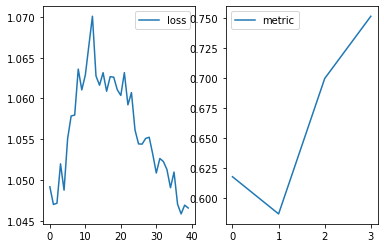

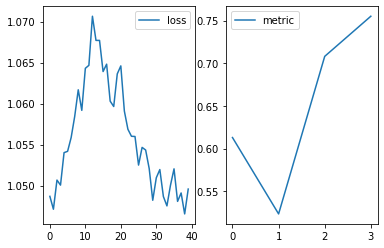

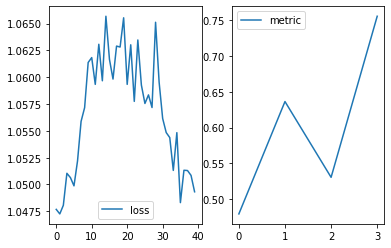

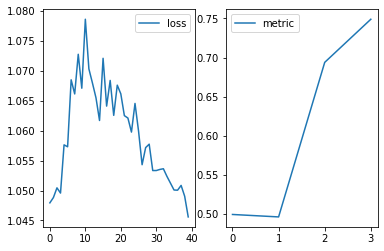

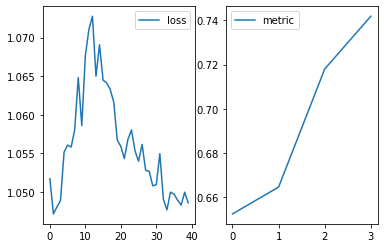

In [39]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])
#post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()



    
model = UNet(
spatial_dims=3,
in_channels=1,
# With softmax 
out_channels=4,
channels=(16, 32, 64, 128,256),
strides=(2, 2, 2, 2),
dropout=0.2,
num_res_units=2,
norm="batch",


)
model.to(device)
if load_weights:
        model.load_state_dict(torch.load(MODEL_FOLDER / weights_file))

optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
for fold in range(start_fold, start_fold + num_folds):    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    #lr_scheduler = LR(optimizer, T_max=10, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            #Apply softmax to labels because they overlap in some cases
            labels = torch.nn.Softmax(dim=1)(labels)
            
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Need to save the fold 4 model to all the other models so that they become the initial condition

Complete
'0_dict_7.pth' to '4_dict_7.pth' copied from '4_dict7.pth' and backups in 'backup dict_7'

### Training phase 8 - use augmentation transforms

In [40]:
#Training settings


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 8
load_weights = True

#tr_transforms = train_transforms[0]
#batch_size = 8

tr_transforms = train_transforms[1]
batch_size = 4

num_epochs = 20
num_folds = 5
start_fold = 0
val_interval = 5
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.OneCycleLR
max_learning_rate = 0.001
min_learning_rate = 0.001


In [41]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()

for fold in range(start_fold, start_fold + num_folds):

    
    model = UNet(
    spatial_dims=3,
    in_channels=1,
    # With softmax 
    out_channels=4,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
    num_res_units=2,
    norm="batch",
    

    )
    model.to(device)
    if load_weights:
            model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))
    
    optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    #lr_scheduler = LR(optimizer, T_max=10, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            #Apply softmax to labels because they overlap in some cases
            labels = torch.nn.Softmax(dim=1)(labels)
            
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/20  LR=3.9999999999999996e-05


  0%|          | 0/55 [00:00<?, ?it/s]

epoch 1 average loss: 1.0414
----------
epoch 2/20  LR=0.00010469028901385913


  0%|          | 0/55 [00:00<?, ?it/s]

epoch 2 average loss: 1.0406
----------
epoch 3/20  LR=0.000281324349835867


  0%|          | 0/55 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
del model

## Inference

In [ ]:
def validation(val_loader,metric_function,model,amp,device):
    
    
    
    post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.2)])

    scaler = torch.cuda.amp.GradScaler() if amp else None
    



    model.eval()
    with torch.no_grad():
        val_images = None
        val_labels = None
        val_outputs = None
        pbar = tqdm(total=len(val_loader))
        metric_function.reset()
        for i, val_data in enumerate(val_loader):
            #if i > 0:
            #    break
            val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)

            sw_batch_size = 4
            if amp:
                with torch.cuda.amp.autocast():
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
            else:

                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)

            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            # compute metric for current iteration
            metric_function(y_pred=val_outputs[0], y=val_labels)
            pbar.update(1)
        pbar.close()

        # aggregate the final mean dice result
        metric = metric_function.aggregate().item()
        print("Metric: "+str(metric))
        # reset the status for next validation round
        metric_function.reset()


        



In [ ]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

In [ ]:
data = iter(val_loader)

In [ ]:
check_data = next(data)

In [ ]:
val_images, val_labels = check_data["img"].to(device), check_data["mask"].to(device)

In [ ]:
with torch.cuda.amp.autocast():
    val_outputs = sliding_window_inference(val_images, roi_size, 4, model)

In [ ]:
val_outputs.shape

In [ ]:
val_outputs2 = [post_trans(i) for i in decollate_batch(val_outputs)][0]

In [ ]:
val_outputs2[0].shape

In [ ]:
val_outputs2[0,3].min()

In [ ]:
val_outputs2 = torch.softmax(val_outputs,dim=1)

In [ ]:
plot_data3d(check_data['img'], val_outputs2.detach(),0,120)

In [ ]:

plot_data3d(check_data['img'], check_data['mask'],0,80)

In [ ]:
def plot_data3d(image, mask,b,start_frame):
    
    img = rearrange(image, 'n c h w d -> n h w d c').cpu().numpy()
    mask = rearrange(mask, 'n c h w d -> n h w d c').cpu().numpy()
    # Plot first 4 images
    fig, ax = plt.subplots(4, 4, figsize=(20,20))
    
    #print(image.shape, img.shape)
    ax = ax.ravel()
    ims = []
    masks = []

    # Start by adding the image to each axis
    for i in range(len(ax)):
        im_min = img[b].min()
        im_max = img[b].max()
        # Plot the i'th image at the starting frame
        im_plot = ax[i].imshow(
            img[b,:,:,start_frame+i,:],
            cmap='bone',
            vmin=im_min,
            vmax=im_max
        )
        #print(mask.max())
        mask_plot = ax[i].imshow(mask[b,:,:,start_frame+i,0:3], alpha=0.3)
        #ims.append(im_plot)
        #masks.append(mask_plot)
        ax[i].axis('off')
    print(im_min, im_max)
    print(img.shape)